In [1]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
import numpy as np
import os
from scipy import stats
from itertools import combinations
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp
import itertools
from IPython.display import display
from scipy.stats import shapiro



In [88]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [89]:
read_dir = "cpi_model_results/"
# os.makedirs(read_dir, exist_ok=True)
# Load the wide-format forecast file
forecast_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_forecasts.csv', index_col=0)
mae_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_mae.csv', index_col=0)
rmse_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_rmse.csv', index_col=0)
# # Load the wide-format forecast file
# forecast_df = pd.read_csv("all_forecasts.csv", index_col=0)

In [90]:
print(len(forecast_df))

100


In [91]:
def plot_metric_with_std(metric_df, title):
    plt.figure(figsize=(10, 6))
    for col in metric_df.columns:
        mean_vals = metric_df[col].mean()
        std_vals = metric_df[col].std()
        plt.errorbar([col], [mean_vals], yerr=[std_vals], fmt='o', capsize=5, label=col)

    plt.title(f"{title} Across 100 Sliding Samples (Mean ± Std Dev)")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    # plt.grid(False)
    plt.tight_layout()
    plt.show()


def boxplot_metric_distribution(metric_df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df, palette="Set3")
    plt.title(f"{title} Distribution Across 100 Rolling Samples")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_mae_mirror_barplot(mae_df, title="Mirror Barplot of MAE and Deviation"):
    """
    Creates a mirror barplot showing average MAE (right) and its deviation (left) for each model.
    Parameters:
    - mae_df: DataFrame where each column is a model and each row is an iteration
    """
    # Drop Iteration column if present
    df = mae_df.drop(columns='Iteration', errors='ignore')
    # Compute mean and std
    mae_means = df.mean().sort_values()
    mae_stds = df.std().reindex(mae_means.index)

    models = mae_means.index
    y_pos = np.arange(len(models))

    # Plot
    fig, ax = plt.subplots(figsize=(13, len(models) * 0.5 + 2))

    bar_height = 0.6
    mean_color = 'blue'
    std_color = 'darkorange'

    # Plot bars
    ax.barh(y_pos, mae_means.values, height=bar_height, color=mean_color, alpha=0.4, label='Mean MAE')
    ax.barh(y_pos, -mae_stds.values, height=bar_height, color=std_color, alpha=0.4, label='Std Dev')
    # Text labels
    for i, (model, mean, std) in enumerate(zip(models, mae_means.values, mae_stds.values)):
        # Mean value at the end
        ax.text(mean + 0.002, i, f"{mean:.4f}", va='center', ha='left', fontsize=9, color='black')
        # Std value on left
        ax.text(-std - 0.002, i, f"{std:.4f}", va='center', ha='right', fontsize=9, color='dimgray')

        # Model name inside the bar (centered between mean and std ends)
        center_pos = 0 if mean < 0.2 else mean / 2  # handle small mean case
        ax.text(0, i, model.upper(), va='center', ha='center', fontsize=9, color='black', fontweight='bold')

    # Format
    ax.set_yticks(y_pos)
    ax.set_yticklabels([''] * len(models))  # Hide y-axis labels (since we write them in bars)
    # ax.axvline(0, color='black', linewidth=1.2)
    ax.set_xlabel("MAE (Right: Mean | Left: Std Dev)", fontsize=12)
    ax.set_title(title, fontsize=15, weight='bold', pad=15)
    ax.legend(loc='lower right')
    # ax.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax.grid(False)
    plt.tight_layout()
    plt.show()



def plot_mae_with_highlight_and_bands(mae_df, highlight_models=None, mark_best_model=None, ci=95,
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):

    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model = mark_best_model.upper() if mark_best_model else None

    # Find best periods for mark_best_model
    best_iterations = []
    if mark_best_model:
        for i, row in mae_df.iterrows():
            if row.idxmin().upper() == mark_best_model:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Gray background lines for all models
    for model in mae_melted['Model'].unique():
        model_upper = model.upper()
        if model_upper not in highlight_models and model_upper != mark_best_model:
            data = mae_melted[mae_melted['Model'].str.upper() == model_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, ci=None)

    # Highlighted lines
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                     linewidth=2.2, label=model, color=palette[i], ci=ci)

    # Highlight best-performing spans
    if mark_best_model and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Optional: label this in legend
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10, label=f"{mark_best_model} best period")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations



def plot_mae_with_highlight_bands_btw(mae_df, highlight_models=None, mark_best_model=None, ci=95,
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):
    """
    Plot MAE trajectories for multiple models with confidence intervals.
    Highlights specific models and marks iterations where a designated model
    performs best *among the highlighted models*.

    Parameters:
    - mae_df (pd.DataFrame): DataFrame where columns are model names and rows are iterations (0 to 99).
    - highlight_models (list, optional): List of model names (strings) to highlight with distinct colors.
                                         e.g., ['VAR', 'ARIMA']
    - mark_best_model (str, optional): A single model name (string). Iterations where this model
                                       is the best *among the highlight_models* will be marked.
    - ci (int or 'sd', optional): Confidence interval size for Seaborn lineplot. Default is 95.
                                  Use 'sd' for standard deviation band.
    - title (str): Title of the plot.
    """

    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    # Ensure model names are consistently upper-cased for comparison
    mae_melted['Model'] = mae_melted['Model'].str.upper()

    highlight_models_upper = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model_upper = mark_best_model.upper() if mark_best_model else None

    best_iterations = []
    if mark_best_model_upper and highlight_models_upper:
        # Filter mae_df to include only models that are in highlight_models
        # This creates a DataFrame subset with only the MAE values of interest
        relevant_mae_data = mae_df[[col for col in mae_df.columns if col.upper() in highlight_models_upper]]

        for i, row in relevant_mae_data.iterrows():
            # Find the model with the minimum MAE in the current iteration
            # among the SUBSET of highlighted models
            best_model_in_subset = row.idxmin().upper() # idxmin() returns the column name of the min value

            # If this best model in the subset is our designated mark_best_model
            if best_model_in_subset == mark_best_model_upper:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Determine unique models in the melted DataFrame (now upper-cased)
    all_unique_models_in_df = mae_melted['Model'].unique()

    # Gray background lines for all models NOT specifically highlighted or marked as best
    for model_name_upper in all_unique_models_in_df:
        if model_name_upper not in highlight_models_upper and model_name_upper != mark_best_model_upper:
            data = mae_melted[mae_melted['Model'] == model_name_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, ci=None) # ci=None to remove CI for background

    # Highlighted lines
    # Ensure a consistent color palette if highlight_models is not empty
    if highlight_models_upper:
        palette = sns.color_palette("tab10", len(highlight_models_upper))
        for i, model_to_highlight_upper in enumerate(highlight_models_upper):
            data = mae_melted[mae_melted['Model'] == model_to_highlight_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         linewidth=2.2, label=model_to_highlight_upper, color=palette[i], ci=ci)

    # Highlight best-performing spans for the designated mark_best_model
    if mark_best_model_upper and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Add a legend entry for the marked periods
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10,
                label=f"{mark_best_model_upper} best (among highlighted)")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations




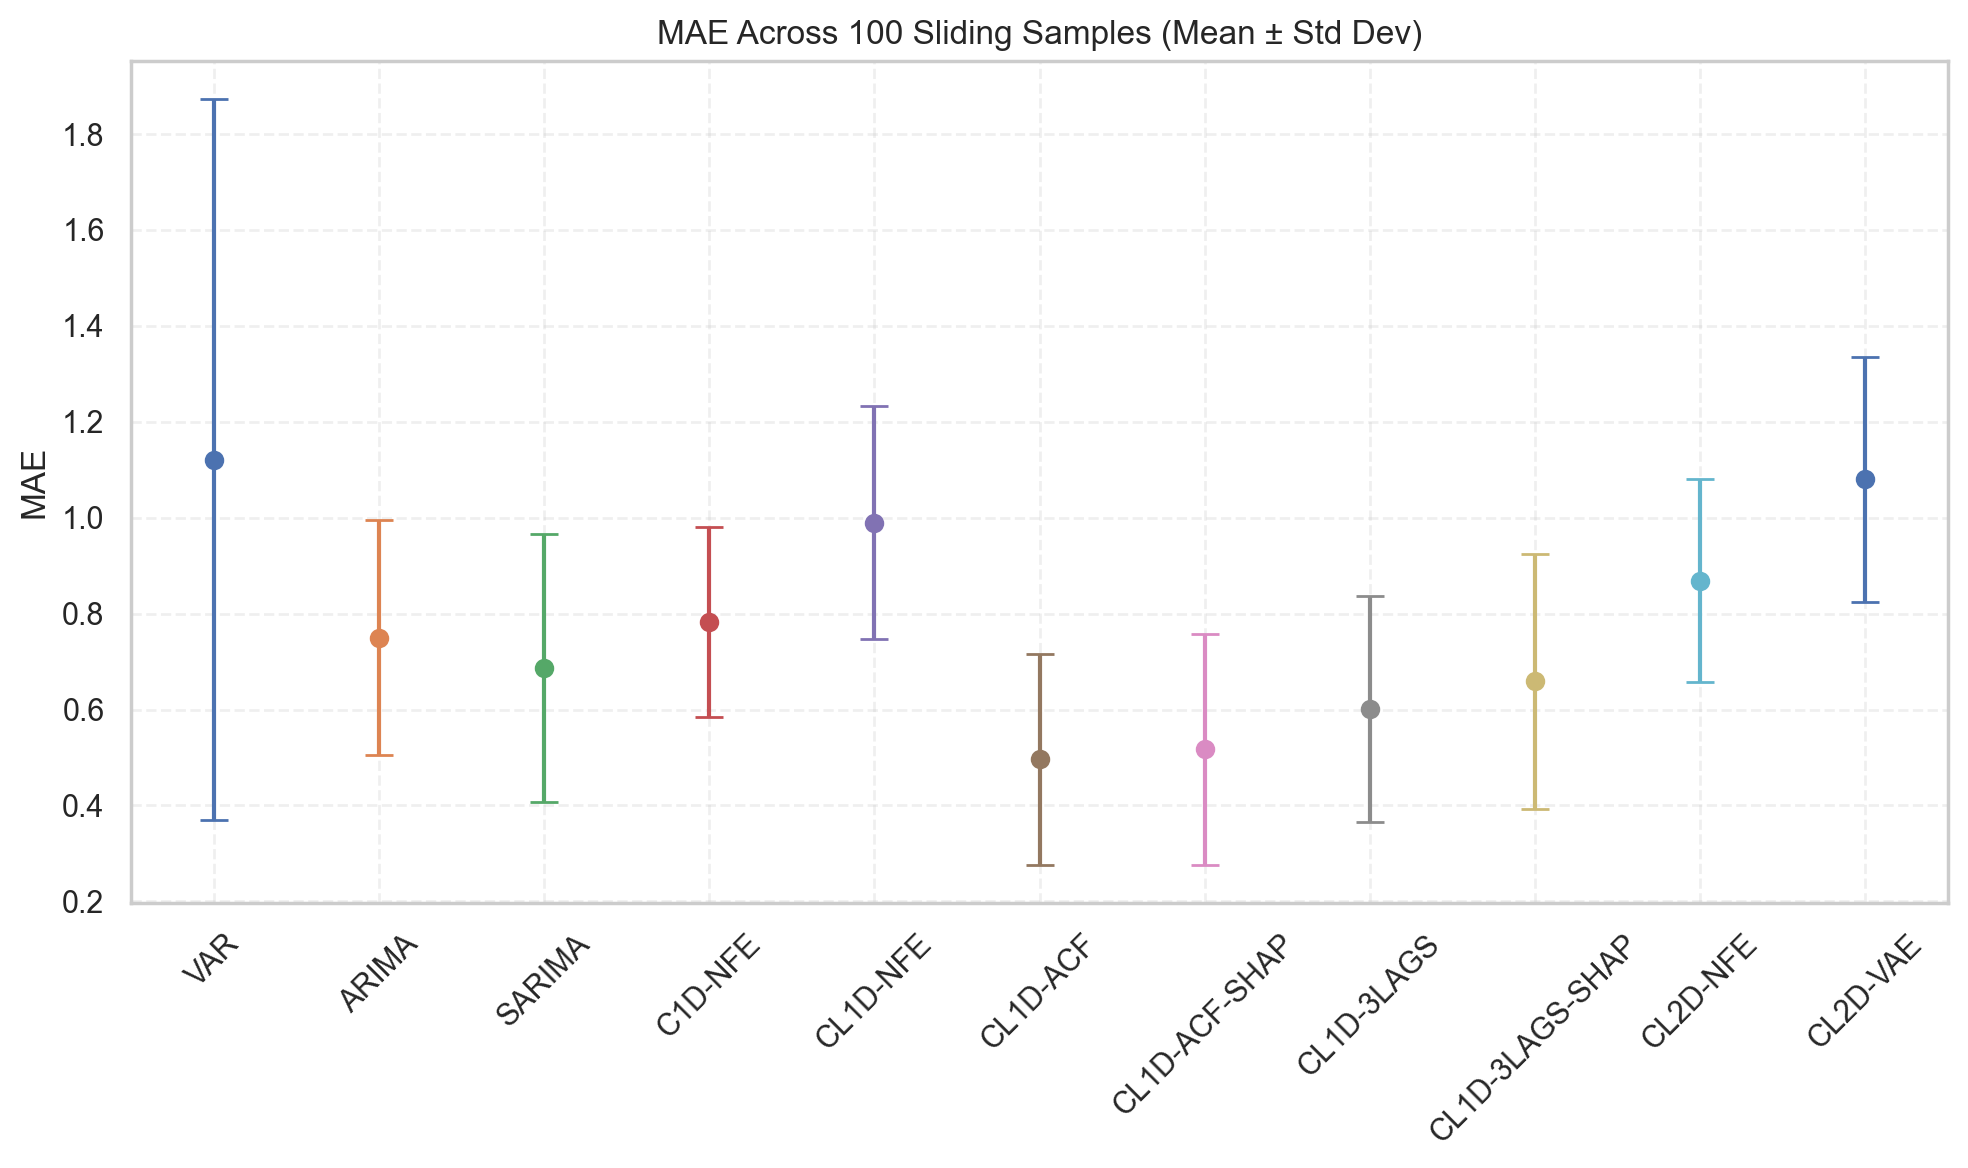

In [92]:
plot_metric_with_std(mae_df, "MAE")
# plot_metric_with_std(rmse_df, "RMSE")

# boxplot_metric_distribution(mae_df, "MAE")
# boxplot_metric_distribution(rmse_df, "RMSE")

In [93]:
# Melt the data for Seaborn
# Reset index to make 'Iteration' a column again
mae_df = mae_df.reset_index()
rmse_df = rmse_df.reset_index()
mae_melted = mae_df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")
rmse_melted = rmse_df.melt(id_vars="Iteration", var_name="Model", value_name="RMSE")

# Compute mean MAE and RMSE per model
mean_mae = mae_df.drop(columns="Iteration", errors='ignore').mean()
mean_rmse = rmse_df.drop(columns="Iteration", errors='ignore').mean()


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_37887/393883759.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)


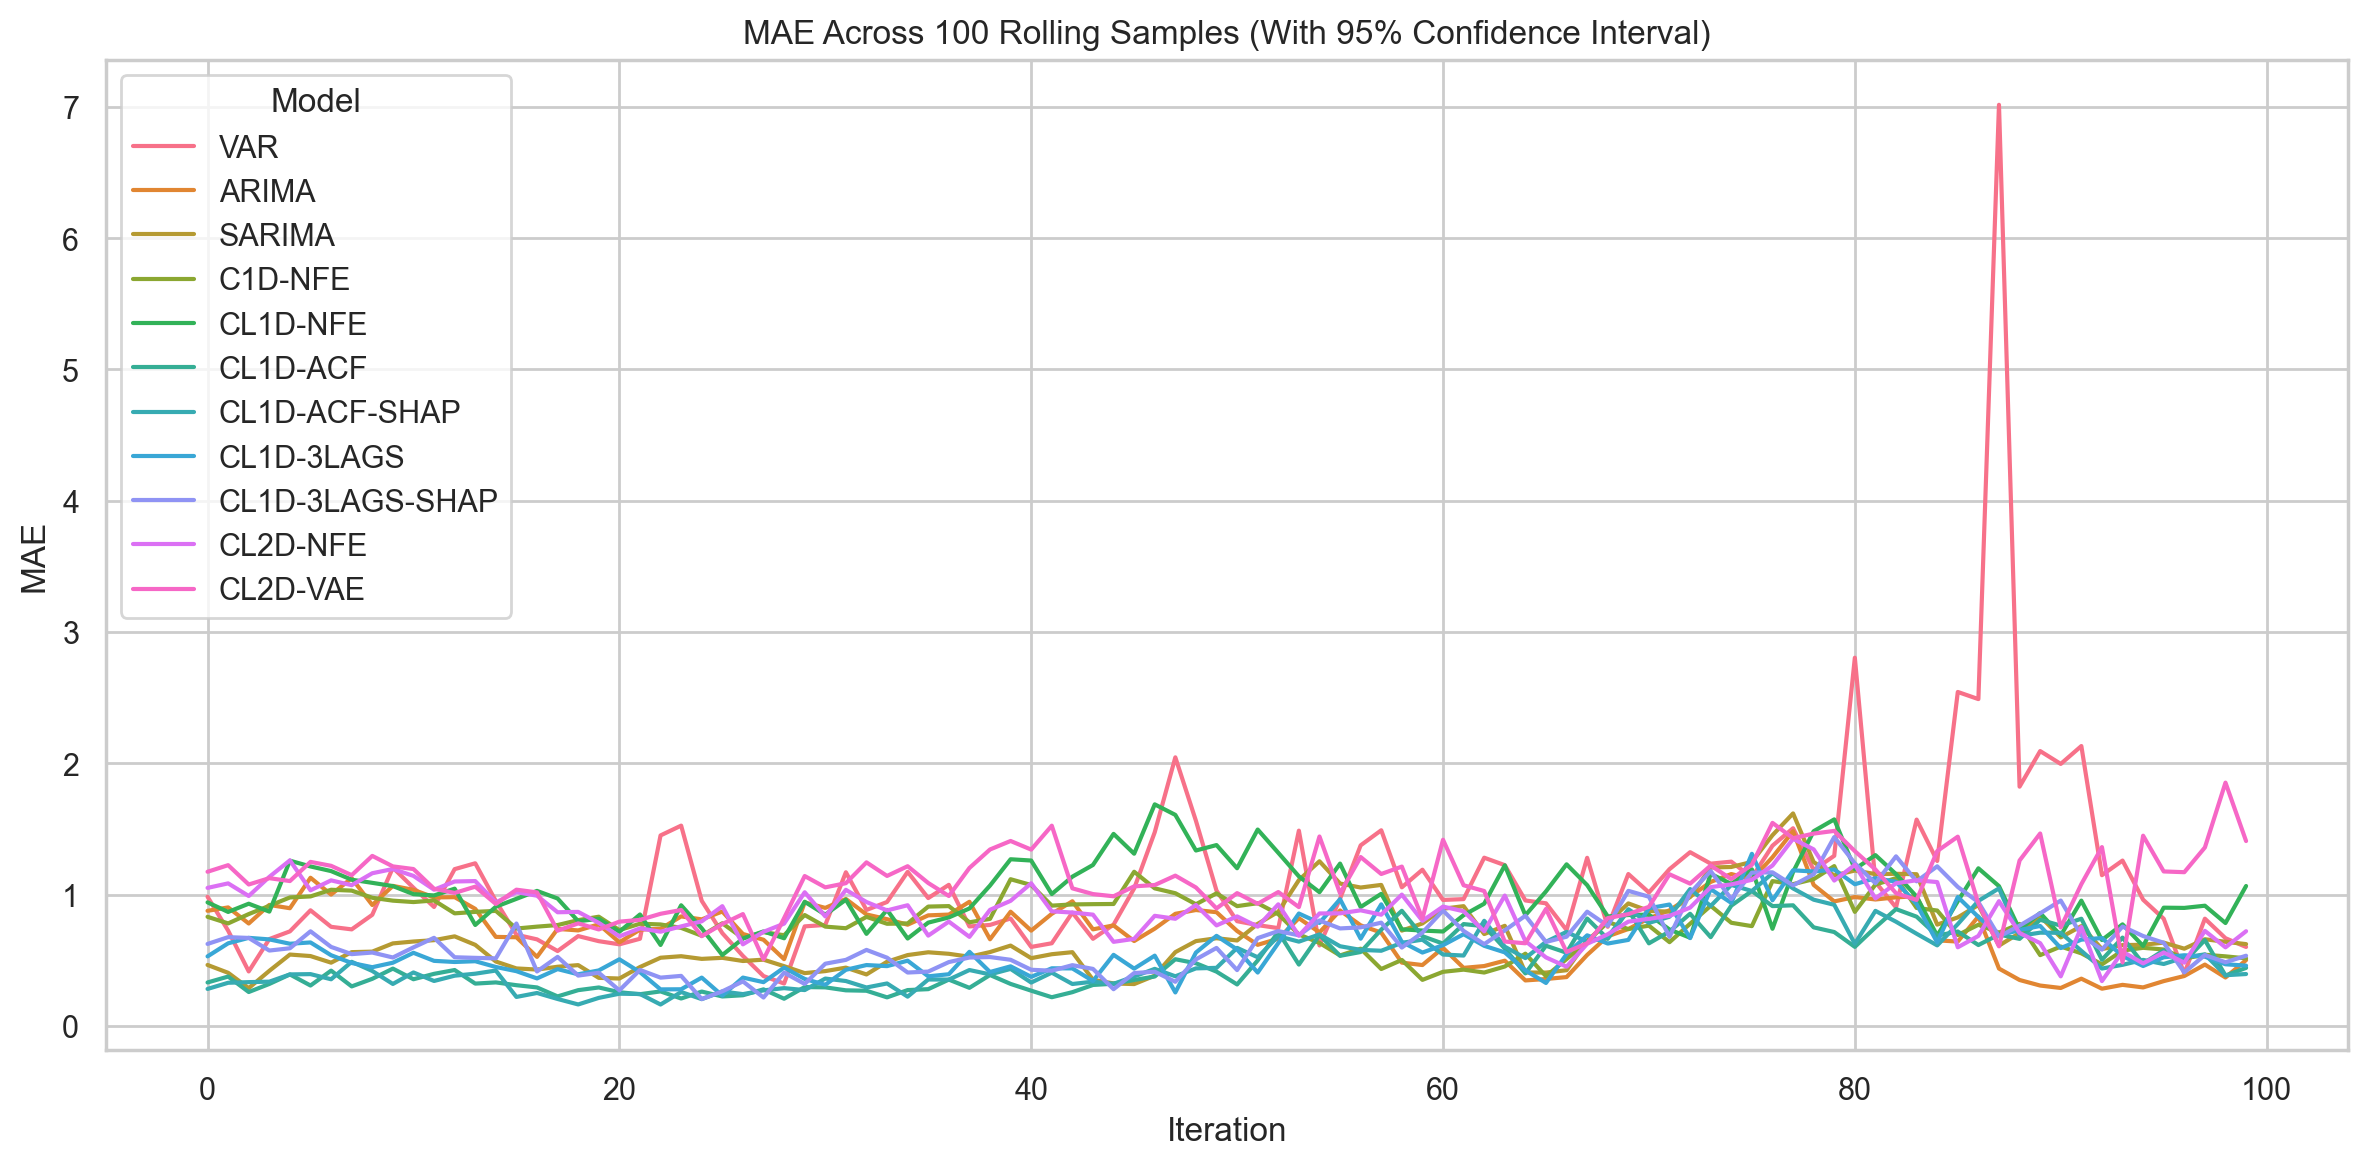

In [94]:

# Plot MAE
plt.figure(figsize=(12, 6))
sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)
plt.title("MAE Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()



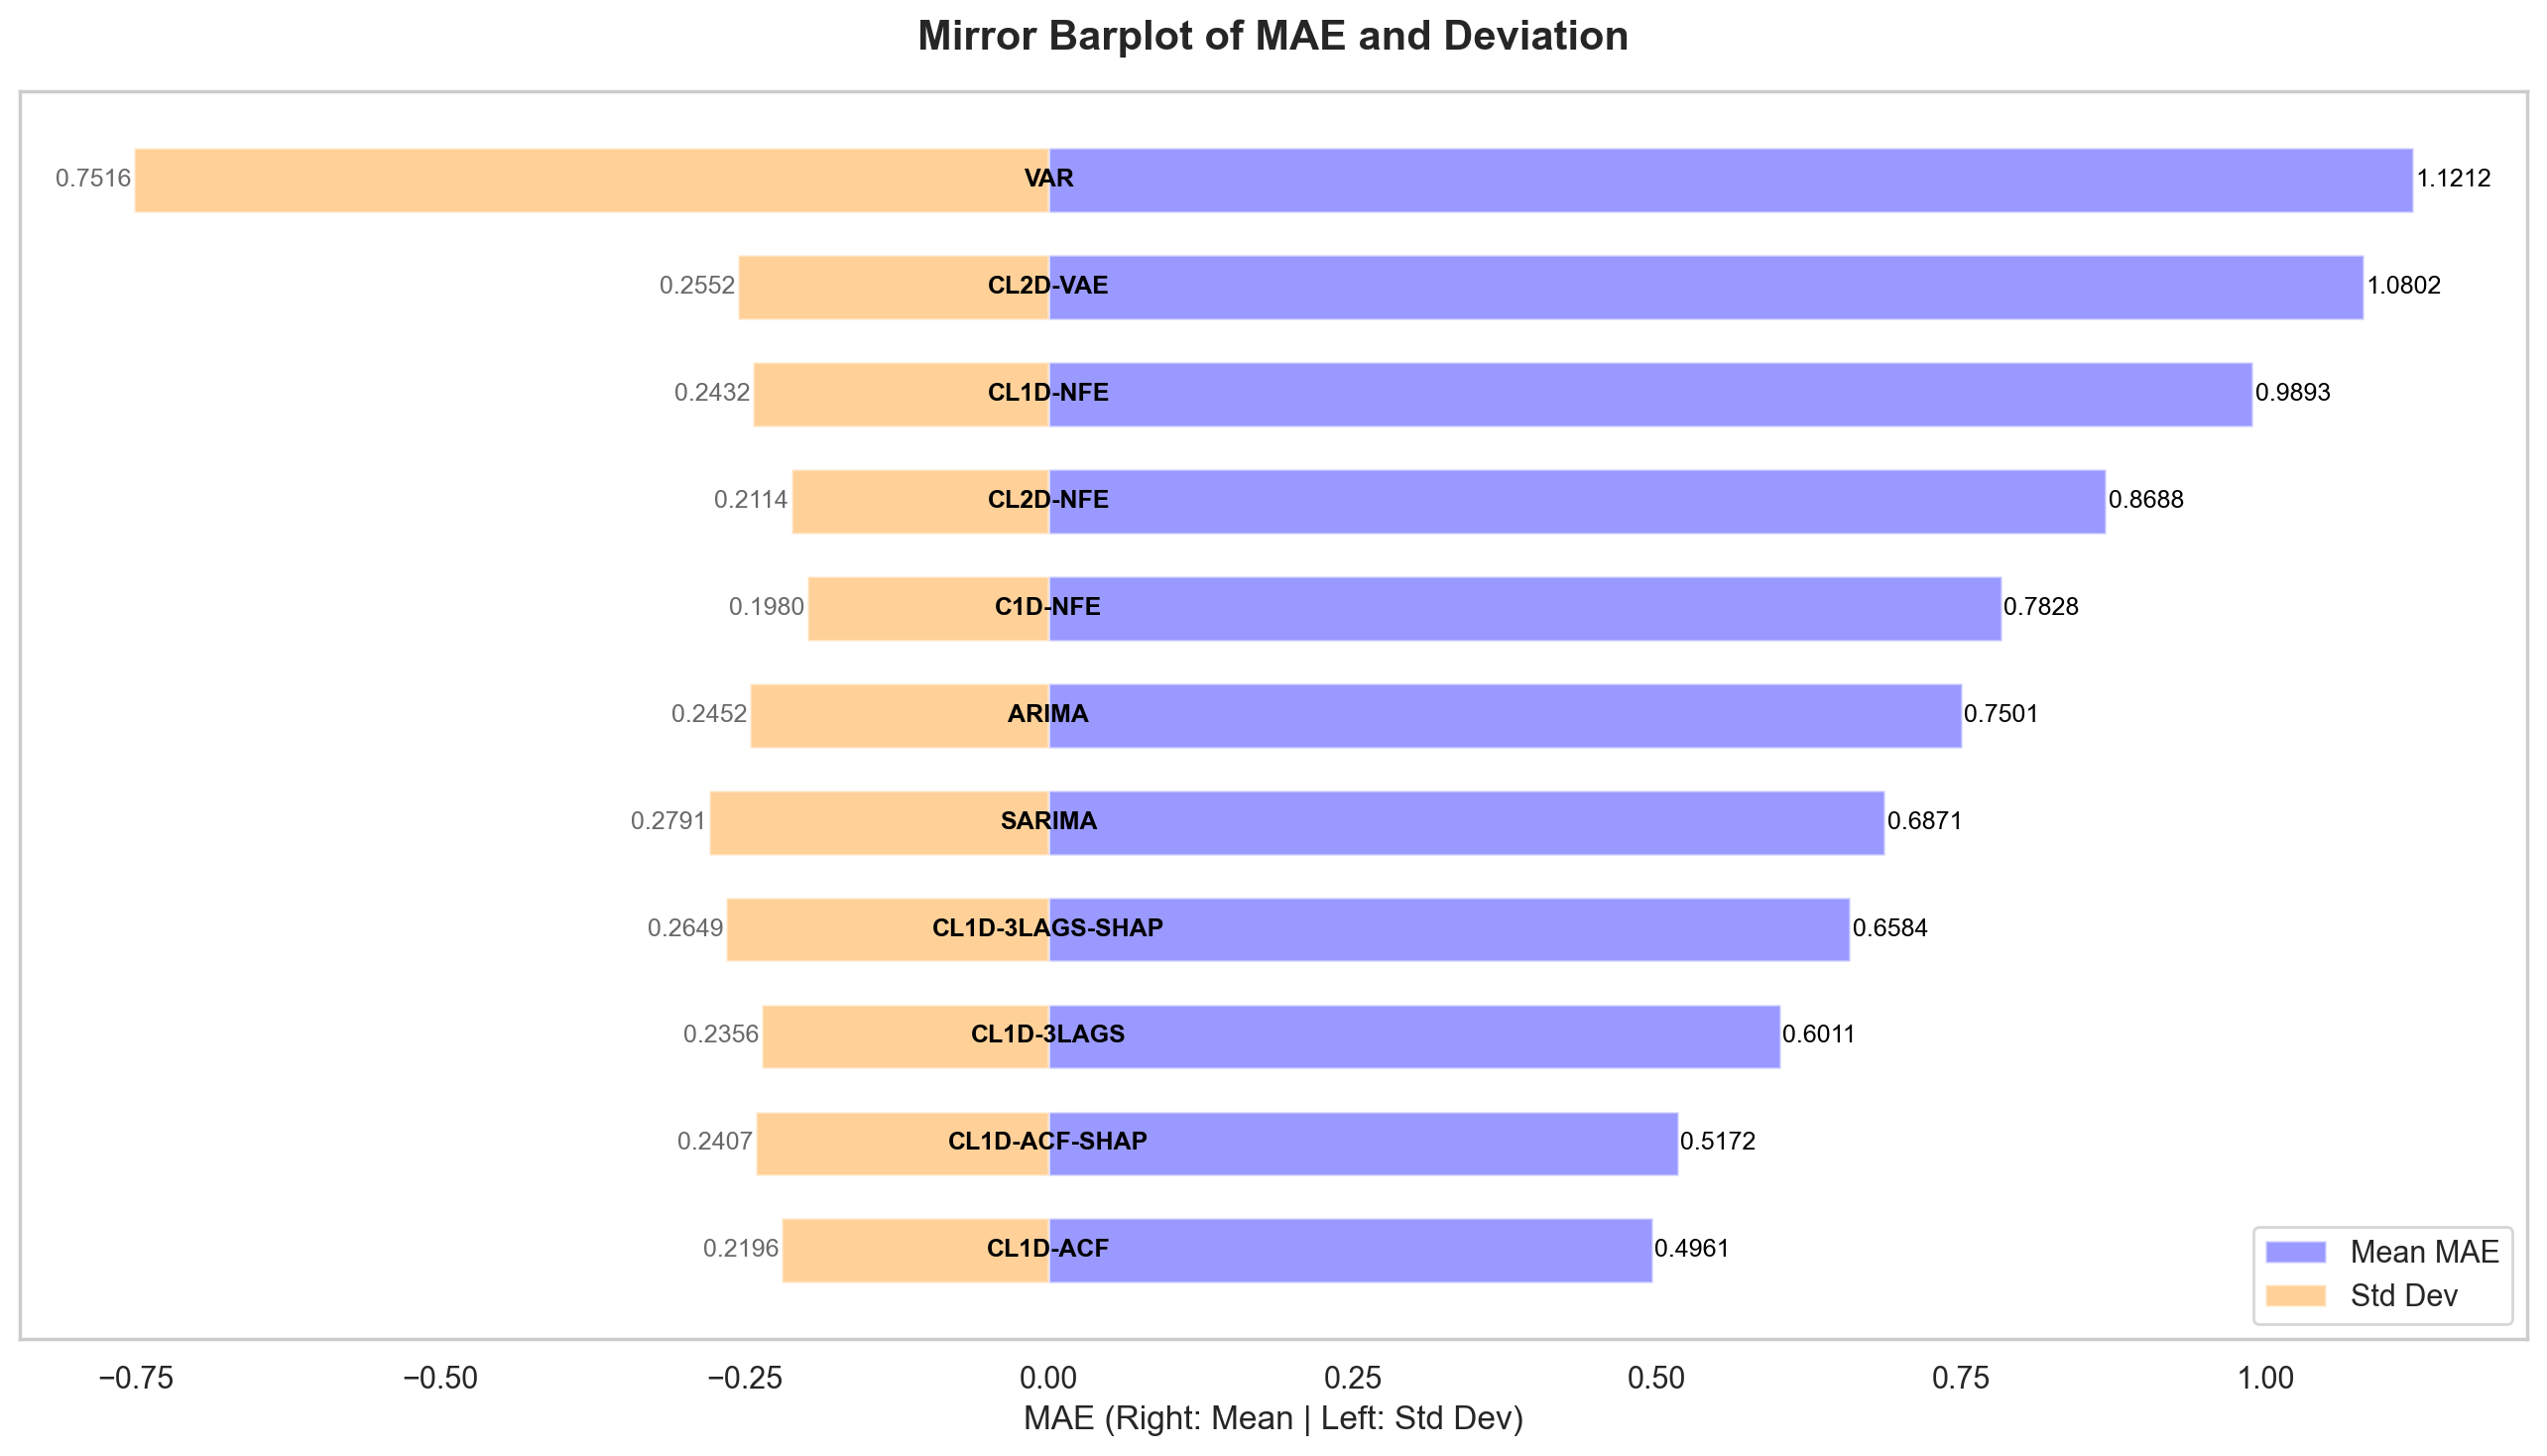

In [95]:
plot_mae_mirror_barplot(mae_df)


In [96]:


def plot_model_performance_panels(mae_df, models_to_plot=None, ci=95, title="MAE Across 100 Iterations (Per Model Highlighted)"):
    """
    Multi-panel line plot of model MAEs over iterations, highlighting one model per panel.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - models_to_plot: List of model names to include (optional)
    - ci: Confidence interval shading for highlighted model (default: 95)
    - title: Title of the figure
    """
    # Reshape to long format
    melted_df = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    melted_df = melted_df.rename(columns={"index": "Iteration"})

    all_models = melted_df['Model'].unique()
    models = [m for m in models_to_plot if m in all_models] if models_to_plot else all_models
    n_models = len(models)
    n_cols = 3
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]

        # Plot all other models in gray
        for other in models:
            if other != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    ci=None, ax=ax
                )

        # Plot the highlighted model
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model.upper(),
            ax=ax, linewidth=2, ci=ci
        )

        ax.set_title(model.upper(), fontsize=10, weight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove()

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, weight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def plot_model_performance_panels_bands(mae_df, models_to_plot=None, ci=95, title="MAE Across 100 Iterations (Per Model Highlighted)"):

    # Ensure iteration index is numeric and 0-based for consistent plotting
    mae_df_processed = mae_df.copy().reset_index(drop=True)
    best_models_per_iteration = mae_df_processed.idxmin(axis=1)

    # Create a mapping from model name to a list of iterations where it was best
    best_iterations_map = {model_name: [] for model_name in mae_df_processed.columns}
    for iter_idx, best_model_name in best_models_per_iteration.items():
        best_iterations_map[best_model_name].append(iter_idx)

    # Prepare DataFrame for melting (for Seaborn plotting)
    melted_df = mae_df_processed.reset_index().rename(columns={"index": "Iteration"})
    melted_df = melted_df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    all_models_in_data = mae_df_processed.columns.tolist() # Get all original model names
    models_to_display = [m for m in models_to_plot if m in all_models_in_data] if models_to_plot else all_models_in_data

    n_models = len(models_to_display)
    if n_models == 0:
        print("No models found to plot. Check 'models_to_plot' and 'mae_df' columns.")
        return

    n_cols = 3 # Number of columns in the subplot grid
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # --- Plotting loop ---
    for i, model in enumerate(models_to_display):
        ax = axes[i]

        # Plot all other models in gray background
        for other_model in all_models_in_data: # Compare against ALL models in the original mae_df
            if other_model != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other_model],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    ci=None, ax=ax # ci=None to remove confidence interval for background lines
                )

        # Plot the current highlighted model's line
        # Use the label parameter here; legend will be created manually later for the figure
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model, # Keep label for potential manual legend creation later
            ax=ax, linewidth=2, ci=ci
        )

        # Highlight periods where the current 'model' is the overall best
        best_periods_for_current_model = best_iterations_map.get(model, [])
        if best_periods_for_current_model:
            for iter_idx in best_periods_for_current_model:
                ax.axvspan(iter_idx - 0.5, iter_idx + 0.5, color='lightgreen', alpha=0.3, lw=0) # Use 'lightgreen' for best periods

        ax.set_title(model, fontsize=11, weight='bold') # Set subplot title to model name
        ax.set_xlabel("Iteration", fontsize=9)
        ax.set_ylabel("MAE", fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis labels if needed
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove() # Remove individual subplot legends to create a single figure legend

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # --- Create a single, unified legend for the entire figure ---
    # This involves getting handles and labels from the plotted lines and the highlight patch
    handles, labels = [], []

    # 1. Add legend entry for the "Best Performance" highlight
    best_performance_patch = plt.Rectangle((0, 0), 1, 1, fc="lightgreen", alpha=0.3, edgecolor='none')
    handles.append(best_performance_patch)
    labels.append("Best Performance (Overall)")

    # 2. Add legend entries for each model's line
    # Iterate through models_to_display to ensure correct order and colors for legend
    # Seaborn automatically assigns colors if not specified. We can retrieve them.
    # This assumes models_to_display are ordered similarly to the internal Seaborn palette.
    for model in models_to_display:
        # Find a line object for the model in the first subplot it was plotted
        line_objects = [line for line in axes[0].get_lines() if line.get_label() == model]
        if line_objects:
            handles.append(line_objects[0]) # Get the first line object for the model
            labels.append(model)
        else: # If model not in first subplot or not found, create a dummy
            dummy_line, = plt.plot([], [], label=model, color=sns.color_palette()[models_to_display.index(model) % len(sns.color_palette())])
            handles.append(dummy_line)
            labels.append(model)

    #
    # fig.legend(handles, labels, loc='lower center', ncol=max(1, len(models_to_display) + 1),
    #            fontsize=9, bbox_to_anchor=(0.5, -0.02)) # Adjust bbox_to_anchor to position legend outside plots


    fig.suptitle(title, fontsize=16, weight='bold')
    # Adjust rect to leave space for the suptitle and the bottom legend
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()




In [97]:
print(mae_df.columns.tolist())

['Iteration', 'VAR', 'ARIMA', 'SARIMA', 'C1D-NFE', 'CL1D-NFE', 'CL1D-ACF', 'CL1D-ACF-SHAP', 'CL1D-3LAGS', 'CL1D-3LAGS-SHAP', 'CL2D-NFE', 'CL2D-VAE']


In [98]:
models_to_plot = ['CL1D_ACF', 'CL1D_ACF_SHAP', 'CL1D_3LAGS', 'CL1D_3LAGS_SHAP']

# plot_model_performance_panels(mae_df, mae_df.columns.tolist(), ci=95)
# mae_df.set_index('Iteration', inplace=True)
# Plot performance panels for all models
plot_model_performance_panels_bands(mae_df, title="Model MAE Across Iterations with Best Periods Highlighted")

#  Plot performance panels for a specific subset of models
# plot_model_performance_panels(mae_df_example, models_to_plot=['VAR', 'CNN', 'LSTM'],
#                               title="Selected Model MAE Across Iterations with Best Periods Highlighted")



AttributeError: 'DataFrame' object has no attribute 'dtype'

In [100]:


def plot_mae_with_highlight(mae_df, highlight_models=None, ci=95, title="MAE Across 100 Rolling Samples (With 95% CI)"):
    """
    Plot MAE over iterations with optional highlighting of selected models.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - highlight_models: List of model names to highlight
    - ci: Confidence interval (default 95)
    - title: Title of the plot
    """
    # Melt the DataFrame to long format
    mae_melted = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    mae_melted = mae_melted.rename(columns={"index": "Iteration"})

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []

    plt.figure(figsize=(14, 7))

    # Plot all models in gray
    for model in mae_melted['Model'].unique():
        data = mae_melted[mae_melted['Model'] == model]
        if model.upper() not in highlight_models:
            sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)

    # Plot highlighted models in color
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", label=model, linewidth=2.2, ci=ci, color=palette[i])

    plt.title(title, fontsize=16)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("MAE", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()


In [101]:
# models_to_plot = ['VAR', 'SARIMA', 'ARIMA', 'CL1D_ACF', 'C1D_NFE', 'CL1D_NFE', 'CL1D_ACF', 'CL1D_ACF_SHAP', 'CL1D_3LAGS', 'CL1D_3LAGS_SHAP']


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_37887/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_37887/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_37887/3709107202.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, ci=None)
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_37887/3709107202.py:23: FutureWarning: 

The `ci` parameter is depre

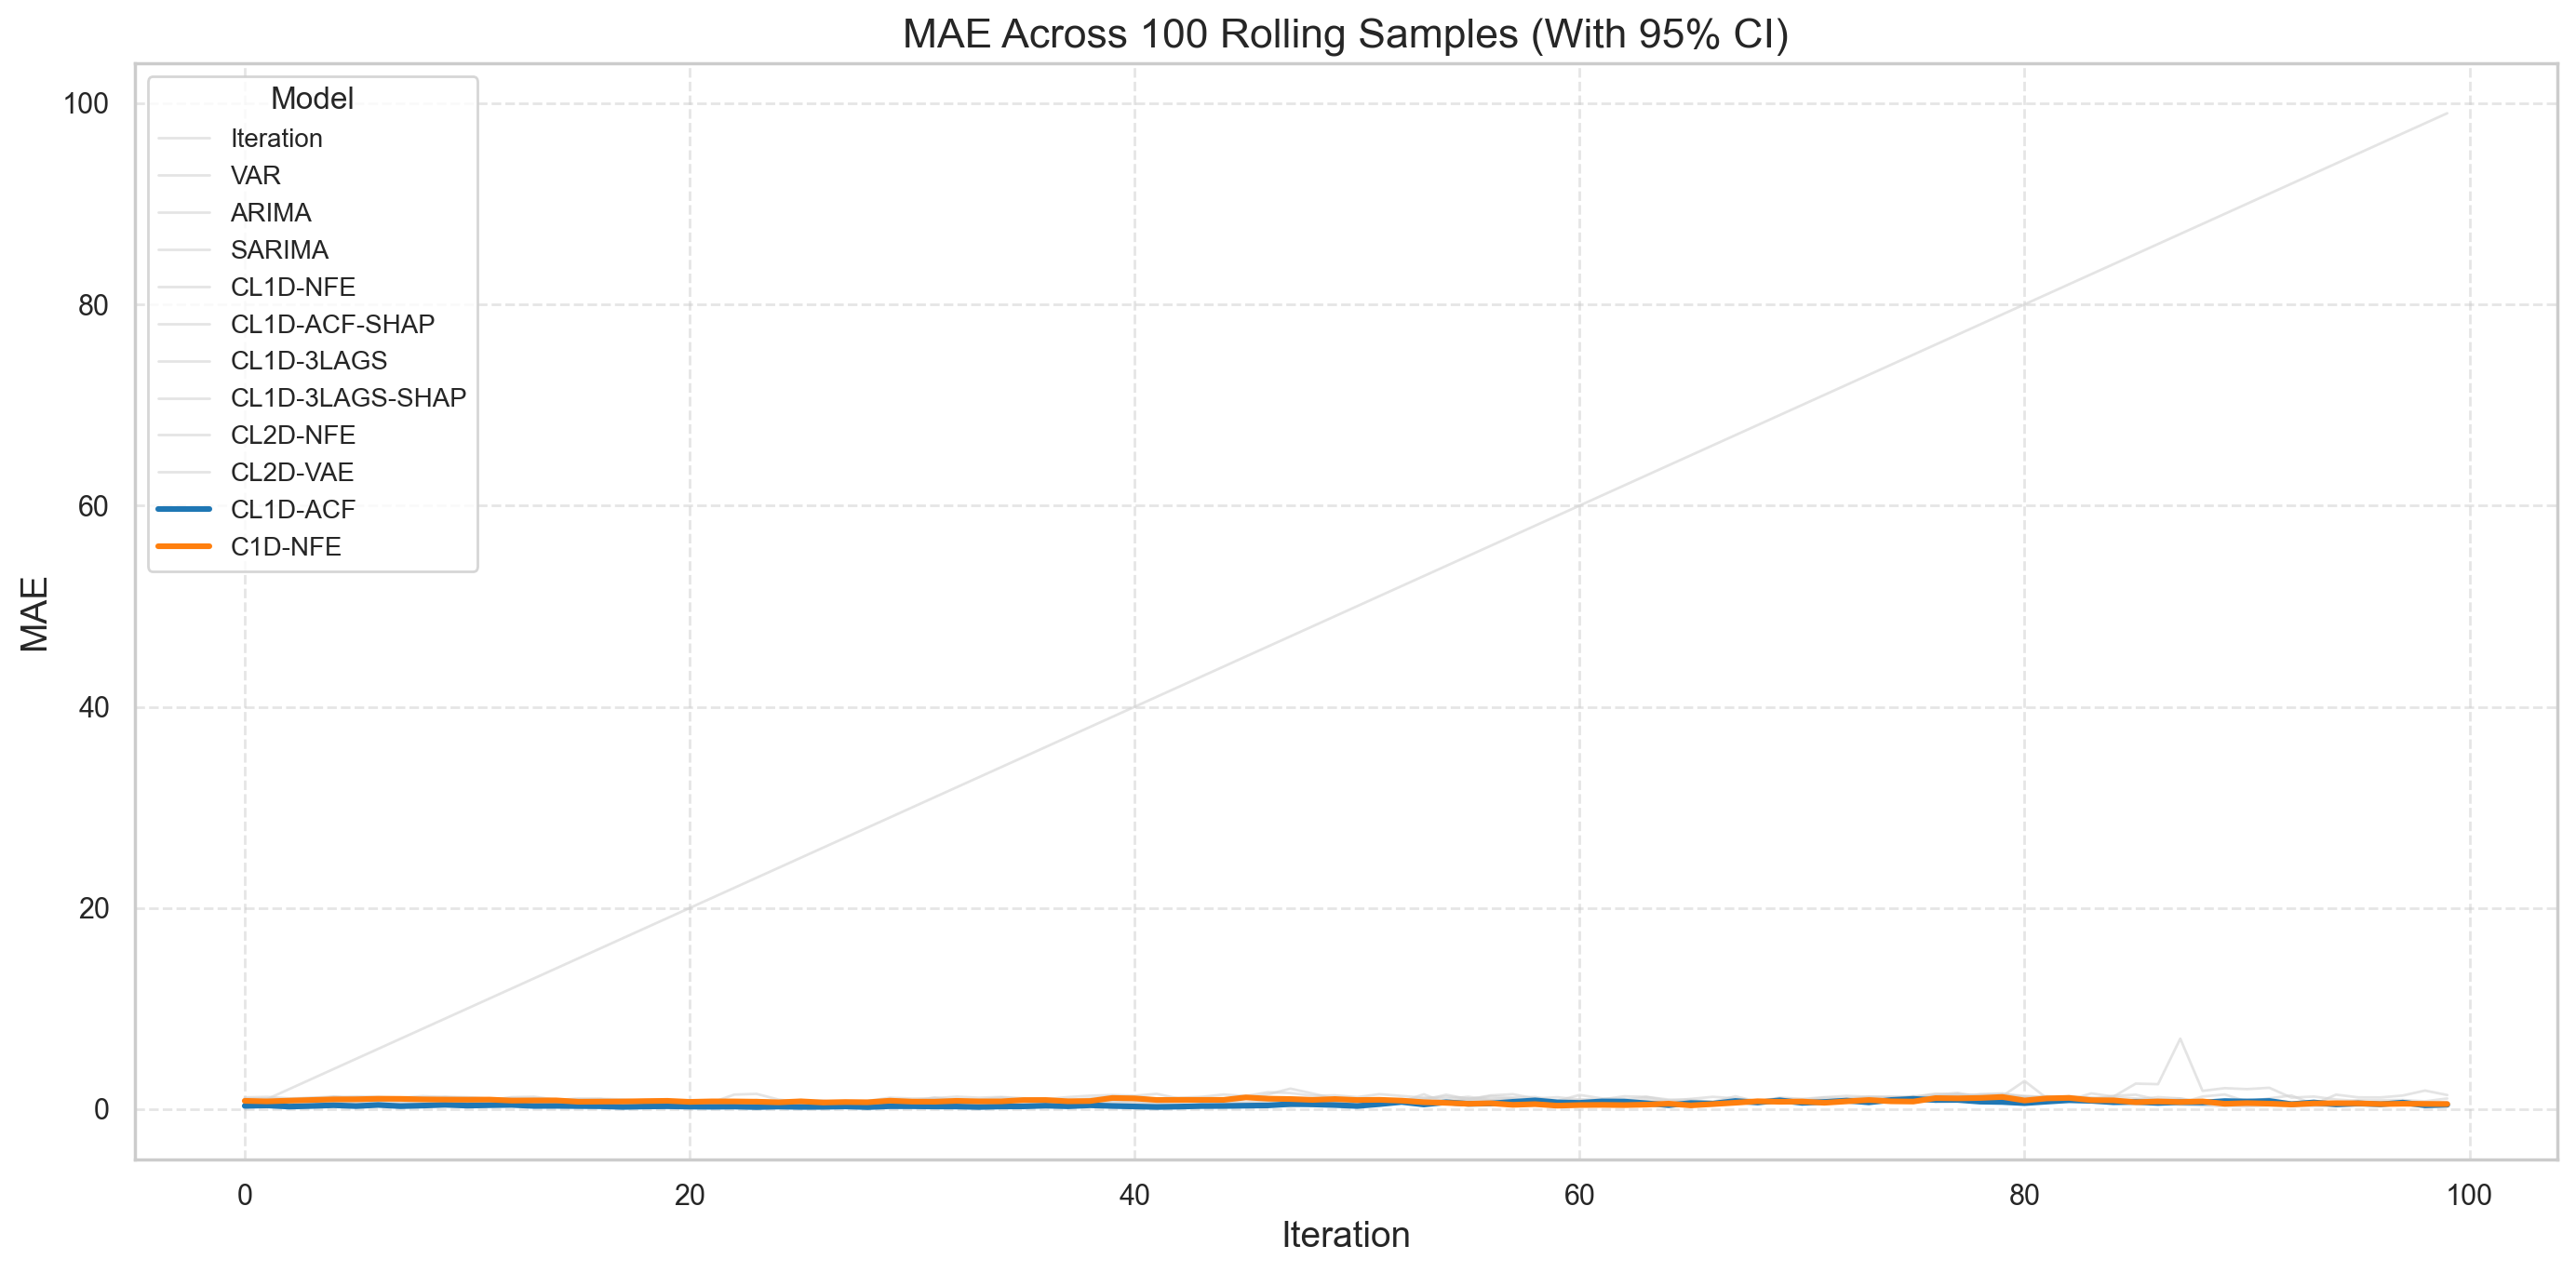

In [102]:
highlight = ['CL1D-ACF', 'C1D-NFE']
plot_mae_with_highlight(mae_df, highlight_models=highlight)


In [103]:
# Highlight two models, and also mark periods where VAR was the best
best_iterations = plot_mae_with_highlight_and_bands(mae_df,
                                         highlight_models=highlight,
                                         mark_best_model='C1D-NFE')


ValueError: cannot insert Iteration, already exists

In [104]:



plot_mae_with_highlight_bands_btw(
    mae_df,
    highlight_models=highlight, # Highlight all dummy models
    mark_best_model='C1D_NFE',         # Check where CNN is best among all dummy models
    title="MAE Plot: C1D-NFE vs CL1D-ACF Best Moments Highlighted"
)



ValueError: cannot insert Iteration, already exists

In [105]:

def calculate_average_forecast_steps(forecast_df, model_prefixes, test_size=12):
    results = {}
    for model_prefix in model_prefixes:
        step_cols = [f"{model_prefix}_step{j+1}" for j in range(test_size)]

        if all(col in forecast_df.columns for col in step_cols):
            # Extract data for the current model's steps
            model_data = forecast_df[step_cols].values # Shape: (num_iterations, test_size)
            # Calculate the mean across the iterations (axis=0) for each step
            mean_across_iterations = np.mean(model_data, axis=0)
            # Store the results
            results[model_prefix] = mean_across_iterations
        else:
            print(f"[Warning] Skipping model '{model_prefix}': Not all forecast step columns found.")

    if not results:
        print("No valid model forecast data found in the DataFrame.")
        return None

    # Convert the dictionary of results to a DataFrame
    # Keys will become index (model names), values will be rows (step averages)
    # Transpose to get models on rows and steps on columns
    average_forecast_df = pd.DataFrame(results).T

    # Rename columns to 'step1', 'step2', etc. for clarity
    average_forecast_df.columns = [f"step{j+1}" for j in range(test_size)]

    return average_forecast_df




In [106]:
# Calculate and print the average forecast for each model and step
average_steps_df = calculate_average_forecast_steps(
    forecast_df,
    mae_df.columns.tolist(),
    test_size=12 # Use the correct test_size for your data
)


[Warning] Skipping model 'Iteration': Not all forecast step columns found.


In [107]:
average_steps_df['Overall Mean'] = average_steps_df.mean(axis=1)
styled_df = average_steps_df.style.highlight_min(axis=0, color='lightgreen')
display(styled_df)


,step1,step2,step3,step4,step5,step6,step7,step8,step9,step10,step11,step12,Overall Mean
VAR,0.685769,1.122531,1.220967,1.328568,1.374523,1.399530,1.298005,1.085135,0.952576,1.029345,1.037485,0.965480,1.124993
ARIMA,0.393812,0.732918,0.823554,0.835644,0.822343,0.789374,0.789434,0.780698,0.775289,0.768488,0.761584,0.772732,0.753823
SARIMA,0.305458,0.650881,0.732559,0.715380,0.718463,0.729030,0.725429,0.718969,0.729407,0.720243,0.730707,0.749509,0.685503
C1D-NFE,0.816277,0.827042,0.842427,0.825219,0.830668,0.808675,0.824956,0.822709,0.834380,0.823774,0.801245,0.794061,0.820953
CL1D-NFE,0.833445,0.964405,0.959448,1.008031,1.019358,0.904373,1.006668,0.972840,0.988052,1.021427,0.884383,0.950409,0.959403
CL1D-ACF,0.461596,0.511646,0.458338,0.500713,0.523734,0.503714,0.541452,0.504200,0.527945,0.549389,0.513998,0.549326,0.512171
CL1D-ACF-SHAP,0.451567,0.477121,0.468795,0.494742,0.507143,0.527216,0.524641,0.527874,0.510301,0.490961,0.533636,0.494254,0.500688
CL1D-3LAGS,0.606918,0.561198,0.556824,0.544934,0.621049,0.646554,0.641566,0.582157,0.612071,0.664938,0.615174,0.629630,0.606918
CL1D-3LAGS-SHAP,0.548224,0.572680,0.582712,0.531403,0.551773,0.560617,0.568597,0.549873,0.546913,0.517948,0.561291,0.579823,0.555988
CL2D-NFE,0.792765,0.830322,0.844224,0.795981,0.800798,0.814029,0.830309,0.784644,0.873474,0.811949,0.795347,0.768598,0.811870


In [105]:
# Starting date of first sample
start_date_first_sample = pd.Timestamp("2002-05-01")
window_length = 172  # 175 months per sample
num_iterations = 100

# Generate all iteration date ranges
iteration_ranges = {}

for i in range(1, num_iterations + 1):
    start = start_date_first_sample + pd.DateOffset(months=i - 1)
    end = start + pd.DateOffset(months=window_length - 1)
    iteration_ranges[i] = (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))

# Example: Print for iteration 53 to 63 (Base CNN winning region)
for i in best_iterations:
    print(f"Iteration {i}: {iteration_ranges[i][0]} to {iteration_ranges[i][1]}")

Iteration 2: 2002-06-01 to 2016-09-01
Iteration 3: 2002-07-01 to 2016-10-01
Iteration 4: 2002-08-01 to 2016-11-01
Iteration 5: 2002-09-01 to 2016-12-01
Iteration 7: 2002-11-01 to 2017-02-01
Iteration 8: 2002-12-01 to 2017-03-01
Iteration 10: 2003-02-01 to 2017-05-01
Iteration 13: 2003-05-01 to 2017-08-01
Iteration 14: 2003-06-01 to 2017-09-01
Iteration 21: 2004-01-01 to 2018-04-01
Iteration 23: 2004-03-01 to 2018-06-01
Iteration 25: 2004-05-01 to 2018-08-01
Iteration 26: 2004-06-01 to 2018-09-01
Iteration 28: 2004-08-01 to 2018-11-01
Iteration 30: 2004-10-01 to 2019-01-01
Iteration 31: 2004-11-01 to 2019-02-01
Iteration 32: 2004-12-01 to 2019-03-01
Iteration 33: 2005-01-01 to 2019-04-01
Iteration 35: 2005-03-01 to 2019-06-01
Iteration 36: 2005-04-01 to 2019-07-01
Iteration 37: 2005-05-01 to 2019-08-01
Iteration 38: 2005-06-01 to 2019-09-01
Iteration 39: 2005-07-01 to 2019-10-01
Iteration 40: 2005-08-01 to 2019-11-01
Iteration 41: 2005-09-01 to 2019-12-01
Iteration 42: 2005-10-01 to 202

In [138]:
# Calculate the average MAE for each model
average_mae_per_model = mae_melted.groupby('Model')['MAE'].mean()

# Sort the models by their average MAE in ascending order (lower MAE is better)
ranked_models = average_mae_per_model.sort_values(ascending=True)

# Identify the overall best model
overall_best_model = ranked_models.index[0]
min_avg_mae = ranked_models.iloc[0]

print("--- Overall Model Performance (Average MAE) ---")
print(ranked_models.to_string()) # .to_string() for better multi-line printing

print(f"\nConclusion: The overall best model is '{overall_best_model}' with an average MAE of {min_avg_mae:.4f}.")


--- Overall Model Performance (Average MAE) ---
Model
CL1D_ACF           0.496094
CL1D_ACF_SHAP      0.517234
CL1D_3LAGS         0.601138
CL1D_3LAGS_SHAP    0.658439
SARIMA             0.687091
ARIMA              0.750070
C1D_NFE            0.782782
CL2D_NFE           0.868835
CL1D_NFE           0.989260
CL2D_VAE           1.080240
VAR                1.121170

Conclusion: The overall best model is 'CL1D_ACF' with an average MAE of 0.4961.


# Significance Test

In [139]:

def test_mae_normality(mae_df, alpha=0.05):
    """
    Tests whether MAE values per model are normally distributed using Shapiro-Wilk test.

    Parameters:
    - mae_df: DataFrame with each model as a column and iterations as rows
    - alpha: Significance level (default = 0.05)

    Returns:
    - DataFrame with p-values and normality conclusion for each model
    """
    results = []

    for model in mae_df.columns:
        stat, p = shapiro(mae_df[model])
        results.append({
            'Model': model,
            'Shapiro-Wilk p-value': p,
            'Normally Distributed': p > alpha
        })

    return pd.DataFrame(results).sort_values(by='Shapiro-Wilk p-value')


In [140]:
normality_results = test_mae_normality(mae_df)
print(normality_results)


              Model  Shapiro-Wilk p-value  Normally Distributed
0               VAR          1.911500e-15                 False
2            SARIMA          1.698569e-06                 False
7        CL1D_3LAGS          4.293941e-06                 False
5          CL1D_ACF          1.048791e-05                 False
6     CL1D_ACF_SHAP          6.097033e-05                 False
8   CL1D_3LAGS_SHAP          4.747964e-04                 False
4          CL1D_NFE          1.464992e-02                 False
1             ARIMA          3.243316e-02                 False
3           C1D_NFE          2.758592e-01                  True
10         CL2D_VAE          7.490771e-01                  True
9          CL2D_NFE          9.791725e-01                  True


Since majority of the models MAES are not normally distributed, we use a non-parametric test

In [146]:

# --- Step 1: Friedman Test (global comparison) ---
stat, p = friedmanchisquare(*[mae_df[col] for col in mae_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4e}")
if p < 0.05:
    print("→ Significant differences between models. Proceeding to post-hoc tests.")
else:
    print("→ No significant differences between models.")


Friedman test statistic: 476.1436, p-value: 5.5039e-96
→ Significant differences between models. Proceeding to post-hoc tests.


Friedman test statistic: 476.1436, p-value: 5.5039e-96
→ Significant differences between models. Proceeding to post-hoc tests.


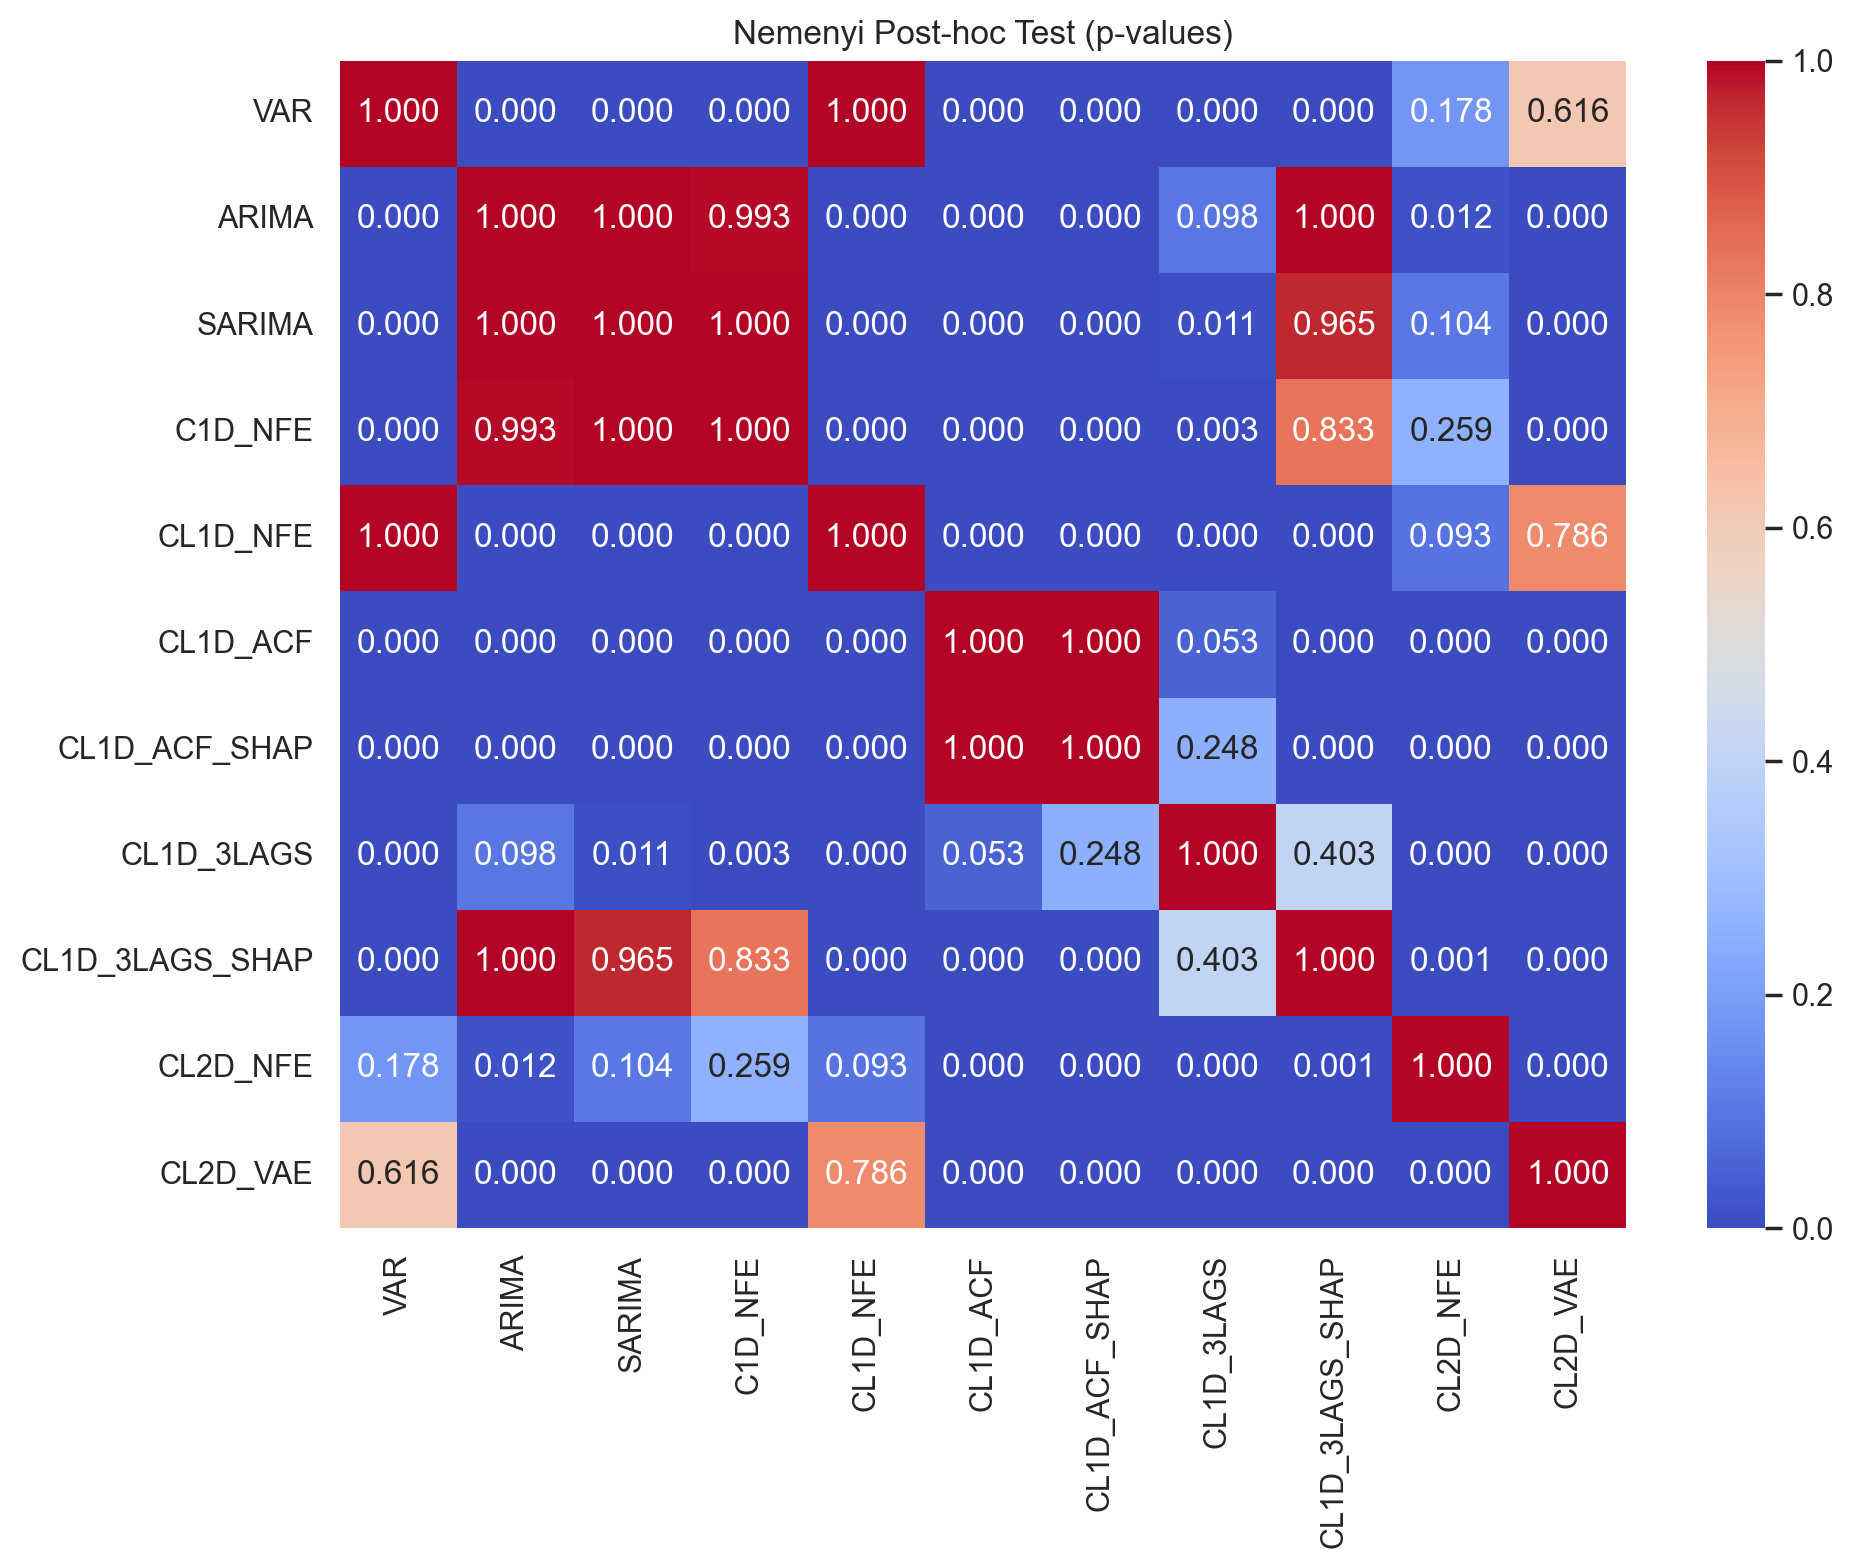

Wilcoxon test between VAR and CL2D_NFE: stat=1629.0000, p-value=2.0649e-03


In [141]:


# --- Step 2: Post-hoc test (Nemenyi) ---
nemenyi_results = sp.posthoc_nemenyi_friedman(mae_df.values)
nemenyi_results.columns = mae_df.columns
nemenyi_results.index = mae_df.columns

# Display heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Nemenyi Post-hoc Test (p-values)")
plt.tight_layout()
plt.show()

# Optional: pairwise Wilcoxon test between specific models
model_a = "VAR"
model_b = "CL2D_NFE"
stat, p = wilcoxon(mae_df[model_a], mae_df[model_b])
print(f"Wilcoxon test between {model_a} and {model_b}: stat={stat:.4f}, p-value={p:.4e}")


In [148]:

# Prepare results list
wilcoxon_results = []

# Generate all model pairs
model_pairs = list(itertools.combinations(mae_df.columns, 2))

# Perform pairwise Wilcoxon tests
for model_a, model_b in model_pairs:
    try:
        stat, p_value = wilcoxon(mae_df[model_a], mae_df[model_b])
        wilcoxon_results.append({
            'Model A': model_a,
            'Model B': model_b,
            'Wilcoxon Stat': stat,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    except Exception as e:
        print(f"Skipped {model_a} vs {model_b}: {e}")

# Convert results to DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results).sort_values(by="p-value")
print(wilcoxon_df)

# Optional: Save to CSV
# wilcoxon_df.to_csv("wilcoxon_model_comparisons.csv", index=False)


            Model A          Model B  Wilcoxon Stat       p-value Significant
4               VAR         CL1D_ACF            7.0  4.813702e-18         Yes
5               VAR    CL1D_ACF_SHAP           16.0  6.311606e-18         Yes
44         CL1D_ACF         CL2D_VAE           31.0  9.893009e-18         Yes
51       CL1D_3LAGS         CL2D_VAE           45.0  1.501327e-17         Yes
48    CL1D_ACF_SHAP         CL2D_VAE           50.0  1.741525e-17         Yes
34         CL1D_NFE         CL1D_ACF           66.0  2.794684e-17         Yes
35         CL1D_NFE    CL1D_ACF_SHAP           87.0  5.175535e-17         Yes
36         CL1D_NFE       CL1D_3LAGS           89.0  5.486894e-17         Yes
18            ARIMA         CL2D_VAE          106.0  8.998385e-17         Yes
6               VAR       CL1D_3LAGS          125.0  1.557920e-16         Yes
53  CL1D_3LAGS_SHAP         CL2D_VAE          186.0  8.820961e-16         Yes
7               VAR  CL1D_3LAGS_SHAP          193.0  1.073291e-1

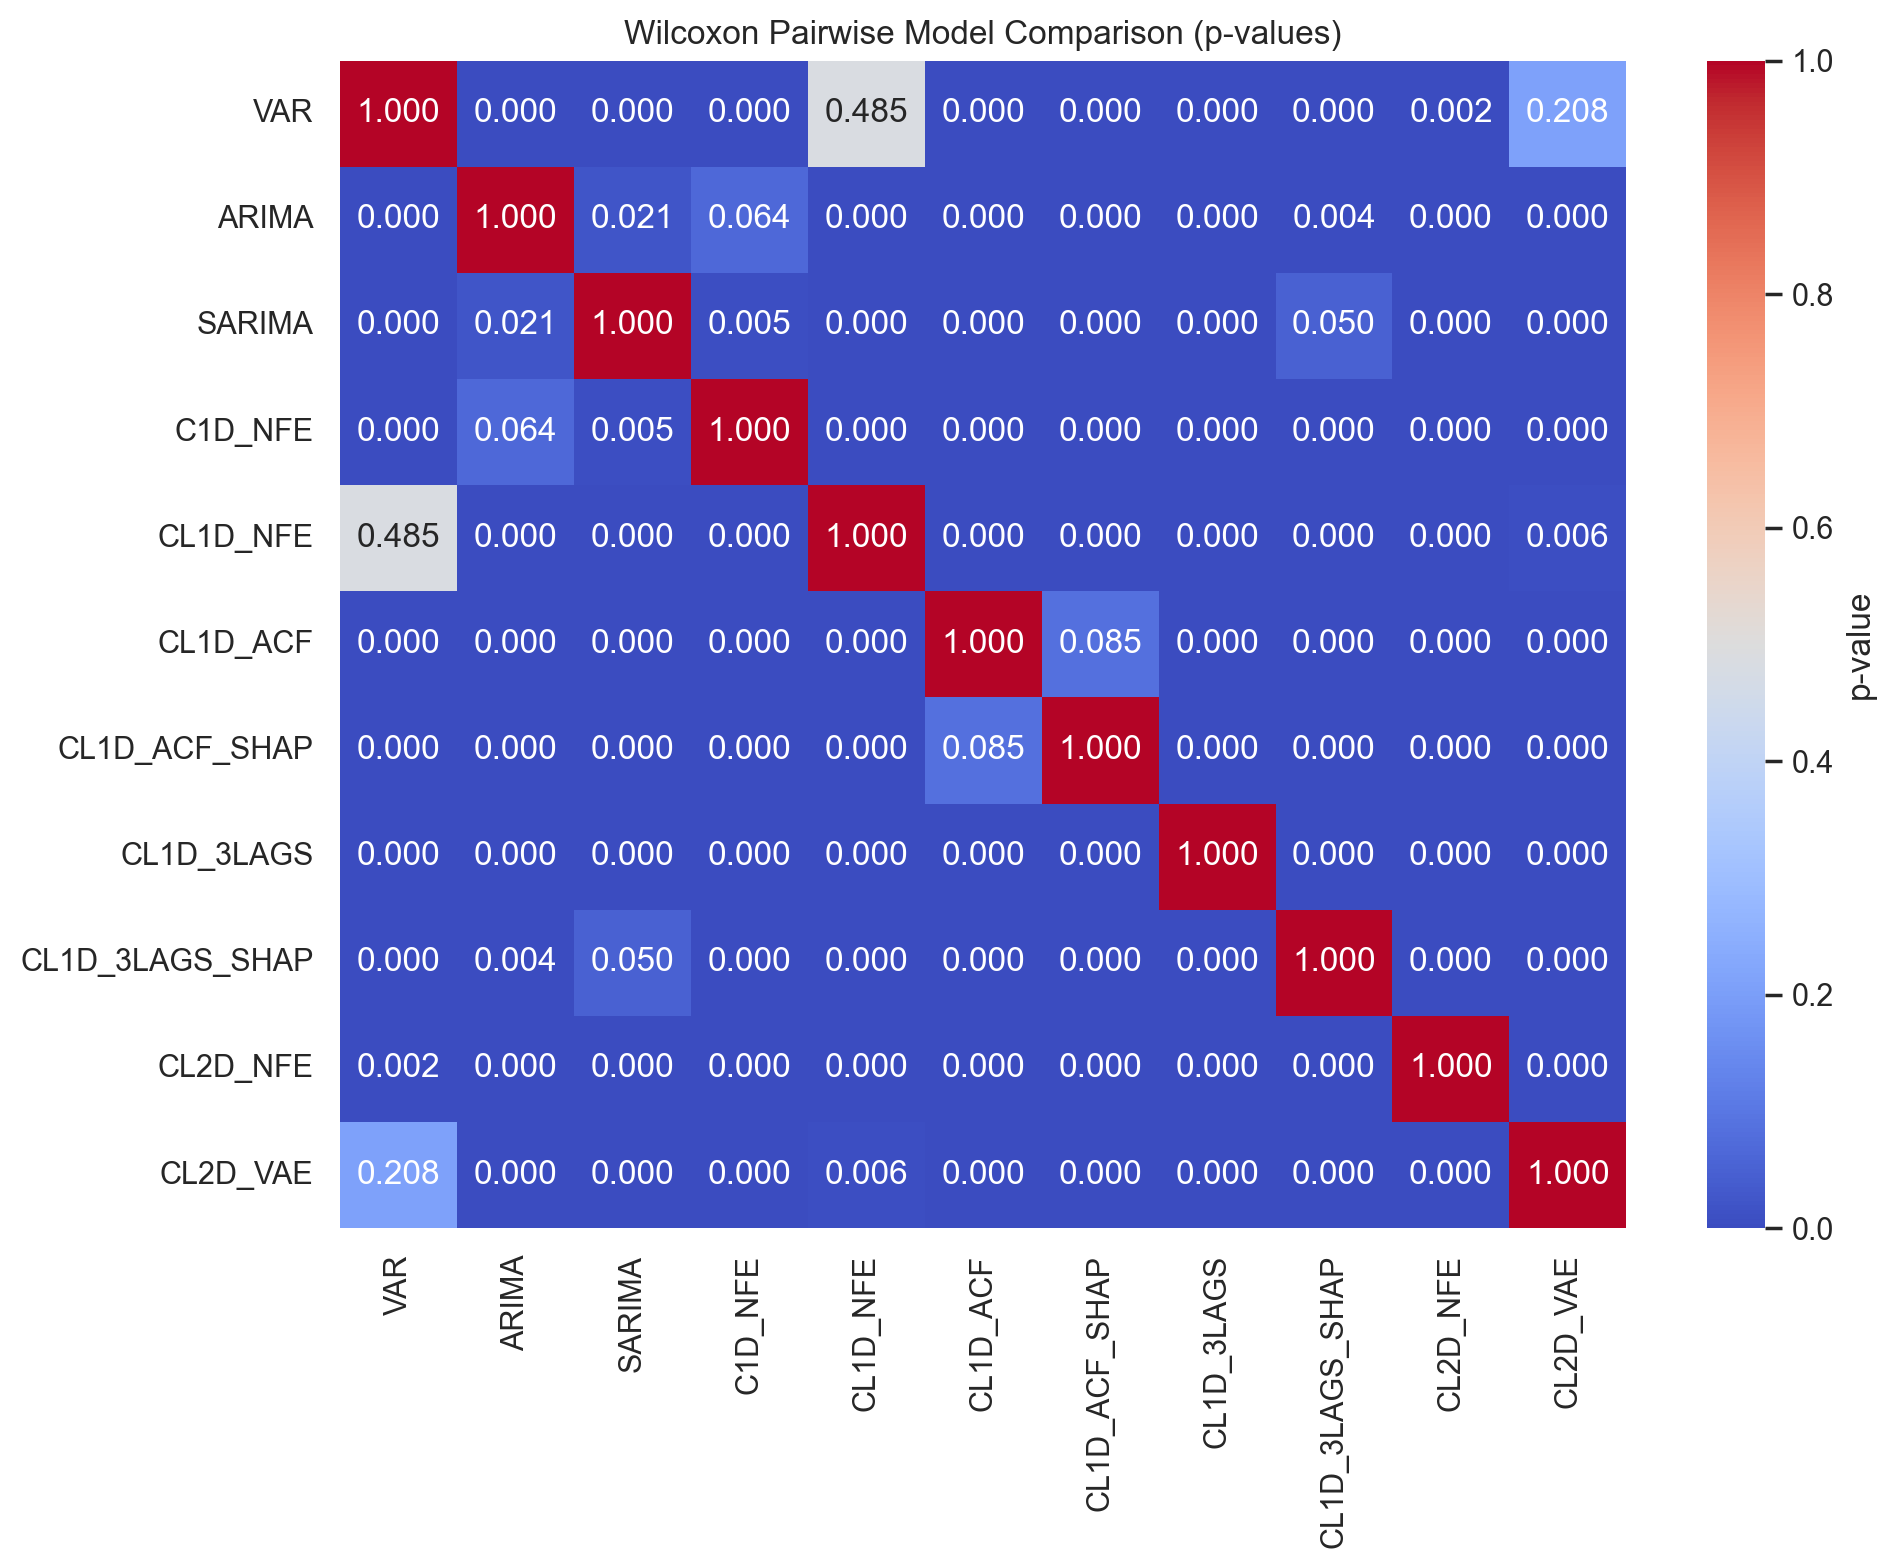

In [149]:

# Create significance matrix
models = mae_df.columns.tolist()
significance_matrix = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)

for _, row in wilcoxon_df.iterrows():
    i, j = row['Model A'], row['Model B']
    significance_matrix.loc[i, j] = row['p-value']
    significance_matrix.loc[j, i] = row['p-value']

# Plot heatmap of p-values
plt.figure(figsize=(10, 8))
sns.heatmap(significance_matrix, annot=True, cmap="coolwarm", fmt=".3f", cbar_kws={"label": "p-value"})
plt.title("Wilcoxon Pairwise Model Comparison (p-values)")
plt.tight_layout()
plt.show()


A regime or macroeconomic structure during this training/test window that aligns well with the base CNN's assumptions or features. What is common across this period is the global financial crisis. The base CNN which has no lagged values performed best consecutively for 11 subsamples. This could most likely infer that in periods of severe macroeconomic shocks,
What Does This Mean for Your Tool? "Having Base Models Perform Better in Periods of Extreme Shocks?"
This observation is significant and provides valuable insights into your models:

Robustness to Regime Shifts: It suggests that your base CNN might be more robust to periods of high volatility and structural breaks in your data. This is a highly desirable property for models used in dynamic environments like finance or economics.
Feature Engineering Importance: It highlights the importance of thoughtful feature engineering. While lagged features are often beneficial, their utility can diminish or even become detrimental during periods where underlying data patterns fundamentally change.
Model Selection and Ensemble Strategies:
For your educational tool, this suggests that a single model might not be optimal across all time periods.
You might consider a hybrid or ensemble approach:
Switching Models: Develop logic to identify periods of high volatility or potential shocks (e.g., based on statistical measures like volatility index, sudden price drops, etc.) and dynamically switch to the base CNN during these times.
Weighted Ensembling: Combine the predictions of different models, perhaps giving more weight to the base CNN during volatile periods and more weight to the lagged models during stable periods.
Further Research:
You could investigate the statistical properties of your time series data during the 2008 crisis period. Did stationarity break down? Were there significant shifts in variance or autocorrelation?
Analyze the features that the base CNN learned during this period. What kind of patterns was it picking up from the non-lagged data that allowed it to outperform?
Consider creating synthetic "shock" events in your data to further test this hypothesis and understand the limits of each model.
In summary, your observation is a strong indicator that the underlying dynamics of your data changed significantly during the 2008 financial crisis, and your base CNN model (which relies on immediate input rather than historical patterns) was better equipped to handle this regime shift or extreme shock. This is a powerful insight into the strengths and weaknesses of your different model architectures


Also the base model starts to perform better towards the end of 2023, 2024.

Germany CPI: Structural Breaks Towards 2023-2024
The period from late 2021 through 2024 has been marked by unprecedented volatility and significant structural breaks in inflation dynamics globally, and particularly in Germany. This period can be broadly characterized by:

Post-COVID Supply Chain Shocks & Pent-up Demand (2021-2022): As economies reopened, a surge in demand met with disrupted global supply chains, leading to initial inflationary pressures.
Energy Crisis (2022 - early 2023): The geopolitical events (especially the war in Ukraine) led to a massive spike in energy prices, particularly natural gas, which heavily impacted Germany due to its reliance on Russian gas. This was a direct, substantial, and immediate shock that drove inflation to multi-decade highs.
Inflation Peaking and Disinflation (Mid-2023 onwards): Following aggressive interest rate hikes by the European Central Bank (ECB), easing energy prices, and some normalization of supply chains, inflation began to decelerate significantly from its peak. This is known as disinflation.


Conclusion: "Base Models Performing Better in Periods of Extreme Shocks and Rapid Regime Shifts"
Your findings consistently point to a crucial characteristic of your base CNN model: it appears to be more robust and adaptable during periods of significant economic upheaval, structural breaks, and rapid shifts in data regimes.

Both the 2008 financial crisis (a sharp contraction/downturn) and the post-COVID, energy-crisis, and disinflationary period (periods of extreme volatility and rapid shifts in both directions) challenge models that rely heavily on the stability of past patterns and lagged relationships. In such environments, a model that can react quickly to the most current information, unburdened by potentially misleading historical correlations, seems to gain an advantage.

This is a valuable insight for your tool's design. It suggests that for economic forecasting, especially in volatile times, simpler (in terms of explicit lagged features) or more instantaneously responsive models can be surprisingly effective. This also strengthens the argument for considering adaptive modeling strategies, where different models or ensembles might be favored depending on the prevailing economic conditions.

Conclusion: "Base Models Performing Better in Periods of Extreme Shocks and Rapid Regime Shifts"
Your findings consistently point to a crucial characteristic of your base CNN model: it appears to be more robust and adaptable during periods of significant economic upheaval, structural breaks, and rapid shifts in data regimes.

Both the 2008 financial crisis (a sharp contraction/downturn) and the post-COVID, energy-crisis, and disinflationary period (periods of extreme volatility and rapid shifts in both directions) challenge models that rely heavily on the stability of past patterns and lagged relationships. In such environments, a model that can react quickly to the most current information, unburdened by potentially misleading historical correlations, seems to gain an advantage.

This is a valuable insight for your tool's design. It suggests that for economic forecasting, especially in volatile times, simpler (in terms of explicit lagged features) or more instantaneously responsive models can be surprisingly effective. This also strengthens the argument for considering adaptive modeling strategies, where different models or ensembles might be favored depending on the prevailing economic conditions.

In [ ]:
model_name_mapper = {
    'sarima': 'SARIMA',
    'arima': 'ARIMA',
    'var': 'VAR',
    'c1d_nfe': 'CONV 1D NFE',
    'cl1d_3lags': 'CONVLSTM 1D 3LAGS FE',
    'cl1d_3lags_shap': 'CONVLSTM 1D 3LAGS + SHAP FE',
    'cl1d_acf': 'CONVLSTM 1D ACF/PACF FE',
    'cl1d_acf_shap': 'CONVLSTM 1D ACF/PACF + SHAP FE',
    'cl2d_nfe': 'CONVLSTM 2D NFE',
    'cl2d_vae': 'CONVLSTM 2D VAE'
}

In [126]:

def plot_model_forecast_errors(forecast_df, model_prefixes, test_size=12, title="Average Forecasts with ±1 Std Dev"):
    """
    Plot average forecast error trajectories for multiple models with confidence intervals.
    Parameters:
    - forecast_df: DataFrame with columns like 'VAR_step1'...'VAR_step12'
    - model_prefixes: List of model name prefixes to plot
    - test_size: Number of forecast steps (e.g., 12 for monthly forecasts)
    - title: Title of the plot
    """

    # Custom colors by model name (lowercase)
    color_map = {
        'cnn': 'blue',
        'cnn_5lags': 'green',
        'cnn_acf_pacf': 'orange',
        'cnn_shap': 'darkred',
        'sarima': 'deeppink',
        'arima': 'indigo',
        'var': 'black',
        'c1d_nfe': 'cornflowerblue',
        'cl1d_3lags': 'darkgreen',
        'cl1d_3lags_shap': 'crimson',
        'cl1d_acf': 'darkorange',
        'cl1d_acf_shap': 'brown',
        'cl2d_nfe': 'slateblue',
        'cl2d_vae': 'teal'
    }

    # Fallback to a color cycle if name not in color map
    fallback_colors = plt.cm.tab10.colors

    plt.figure(figsize=(14, 7))

    for i, model in enumerate(model_prefixes):
        step_cols = [f"{model}_step{j+1}" for j in range(test_size)]
        if not all(col in forecast_df.columns for col in step_cols):
            print(f"[Skipping] {model}: missing forecast steps")
            continue

        model_data = forecast_df[step_cols].values  # Shape: (100, 12)
        mean_forecast = np.mean(model_data, axis=0)
        std_forecast = np.std(model_data, axis=0)

        model_lower = model.lower()
        color = color_map.get(model_lower, fallback_colors[i % len(fallback_colors)])
        label = model.upper()

        x = np.arange(1, test_size + 1)
        plt.plot(x, mean_forecast, label=label,
                 marker='o', linewidth=2, color=color)

    plt.title(title, fontsize=16)
    plt.xlabel("Forecast Horizon (Months Ahead)", fontsize=14)
    plt.ylabel("Forecasted Value", fontsize=14)
    plt.xticks(np.arange(1, test_size + 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.show()



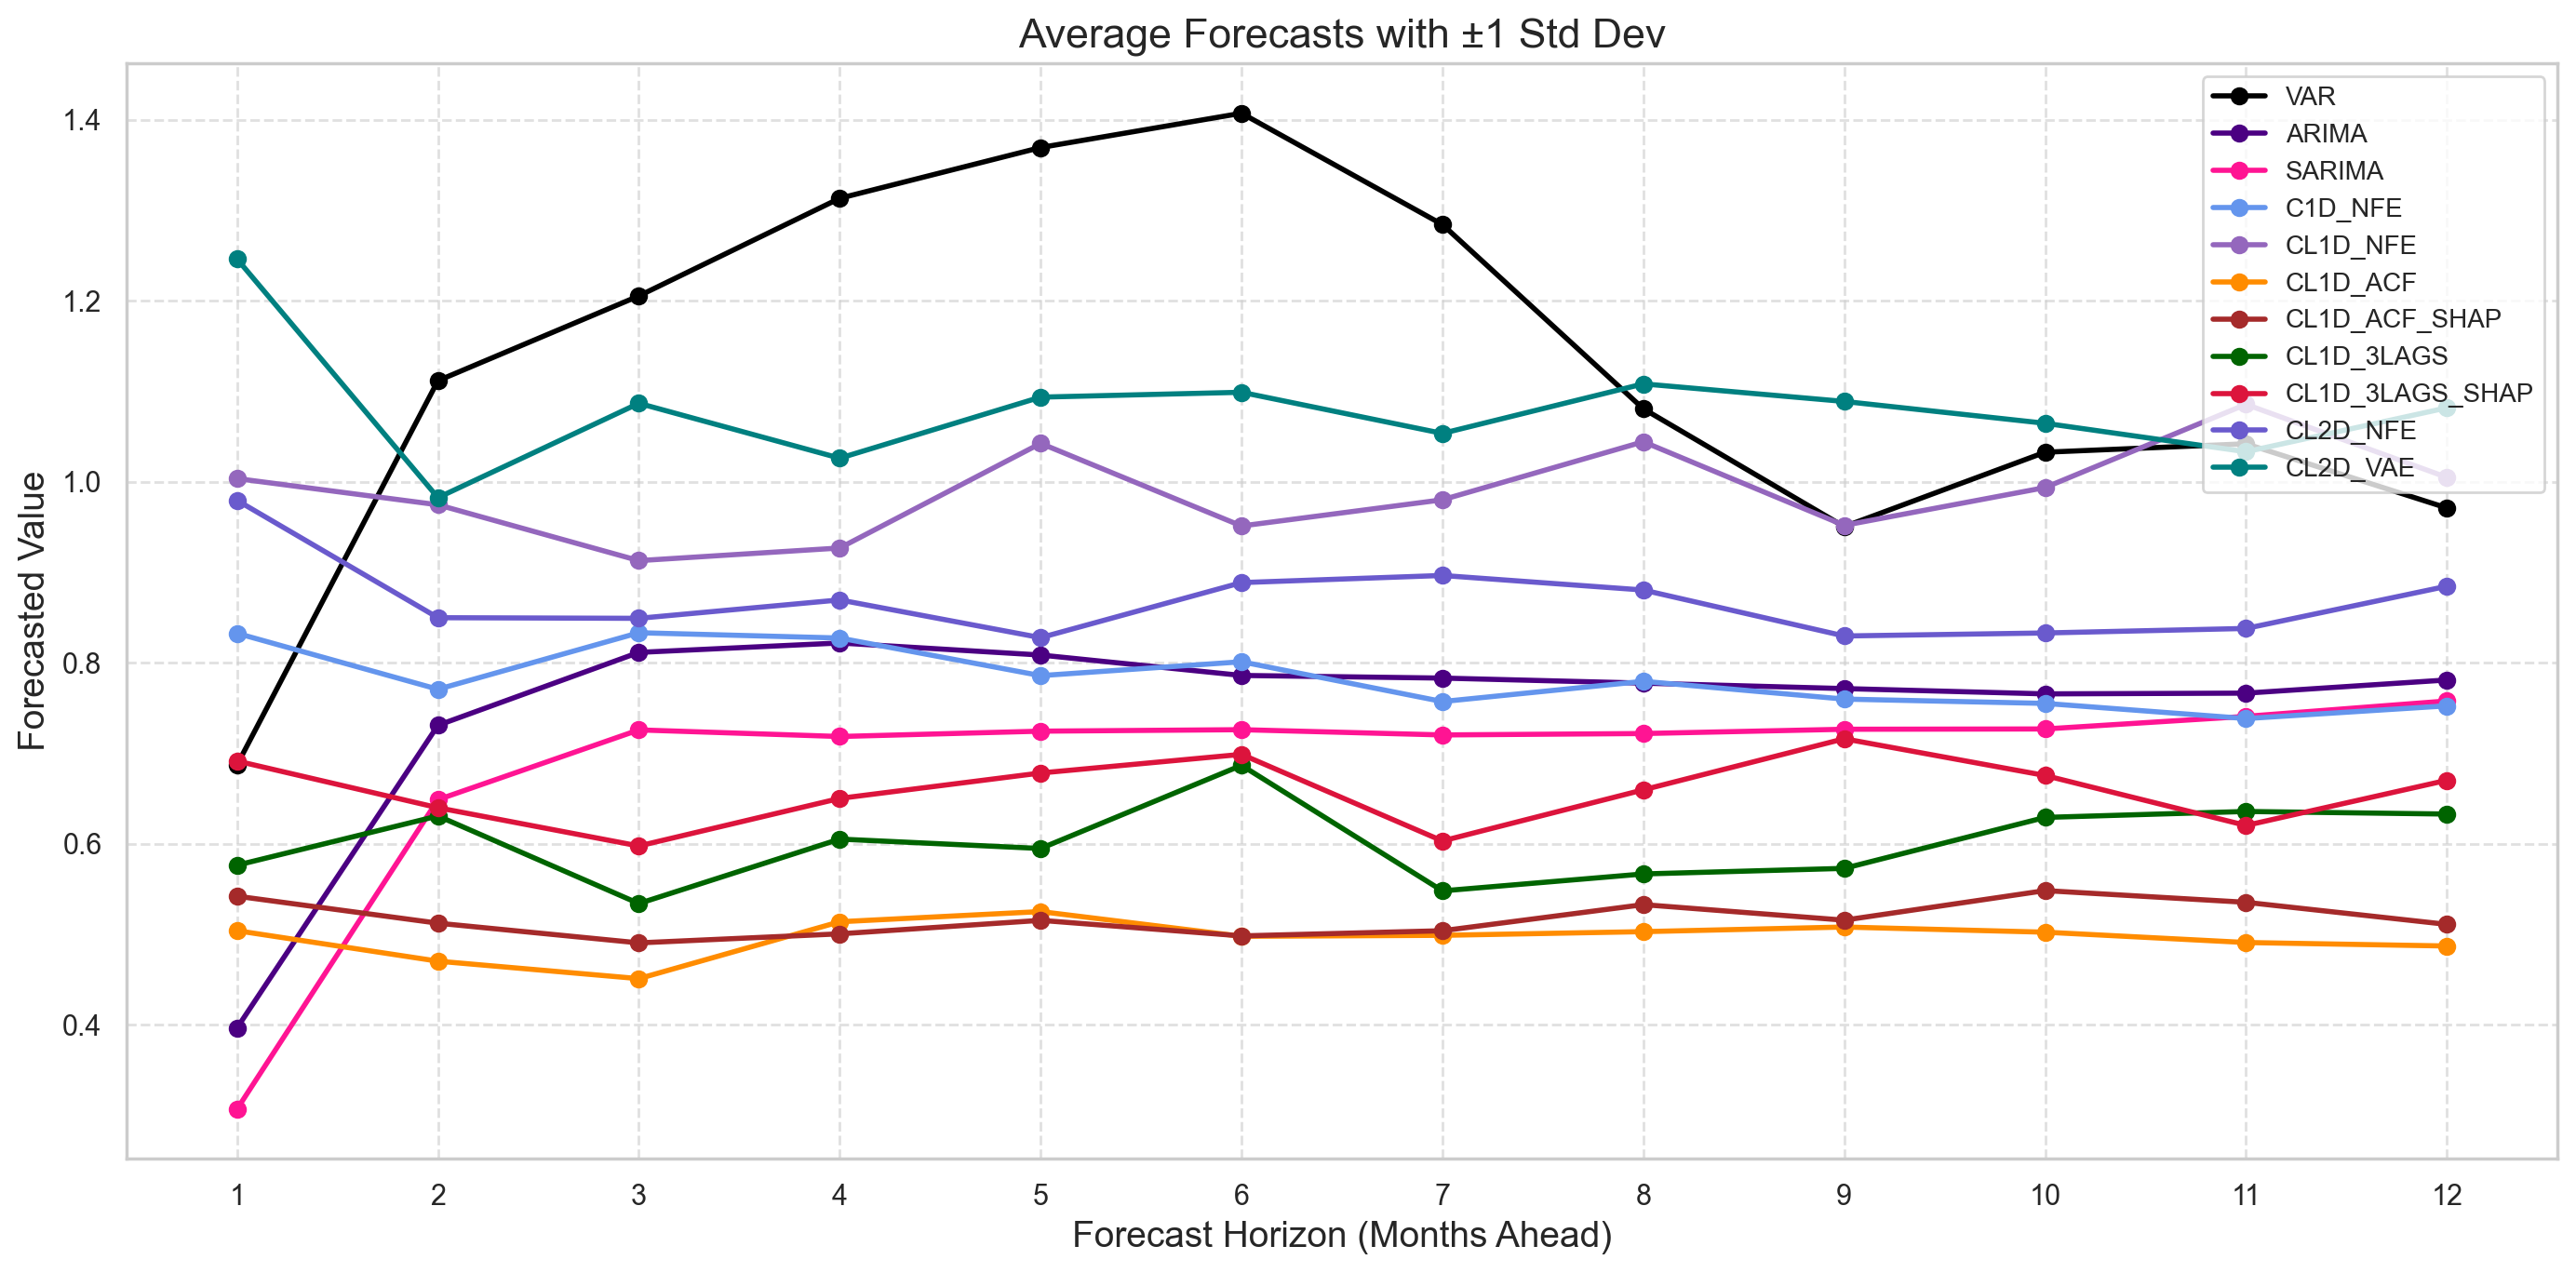

In [127]:
plot_model_forecast_errors(forecast_df, mae_df.columns.tolist())


In [46]:
import math


def plot_multipanel_forecasts_highlighted(forecast_df, model_prefixes, test_size=12, title="Model Forecast Comparison per Step"):
    n_models = len(model_prefixes)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    x = np.arange(1, test_size + 1)

    for i, model in enumerate(model_prefixes):
        ax = axes[i]
        for j, other_model in enumerate(model_prefixes):
            step_cols = [f"{other_model}_step{k+1}" for k in range(test_size)]
            if not all(col in forecast_df.columns for col in step_cols):
                continue

            model_data = forecast_df[step_cols].values
            mean_forecast = np.mean(model_data, axis=0)

            if other_model == model:
                ax.plot(x, mean_forecast, color='blue', linewidth=2, marker='o', label=other_model.upper())
                ax.annotate(f"Mean {mean_forecast[-1]:.2f}",
                            (x[-1], mean_forecast[-1]),
                            textcoords="offset points",
                            xytext=(8, 0),
                            ha='left',
                            fontsize=9,
                            color='blue')
            else:
                ax.plot(x, mean_forecast, color='gray', alpha=0.3)

        ax.set_title(f"{model.upper()}", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xticks(x)

    for ax in axes[n_models:]:
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    fig.supxlabel("Forecast Horizon (Months Ahead)", fontsize=14)
    fig.supylabel("Forecasted Value", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



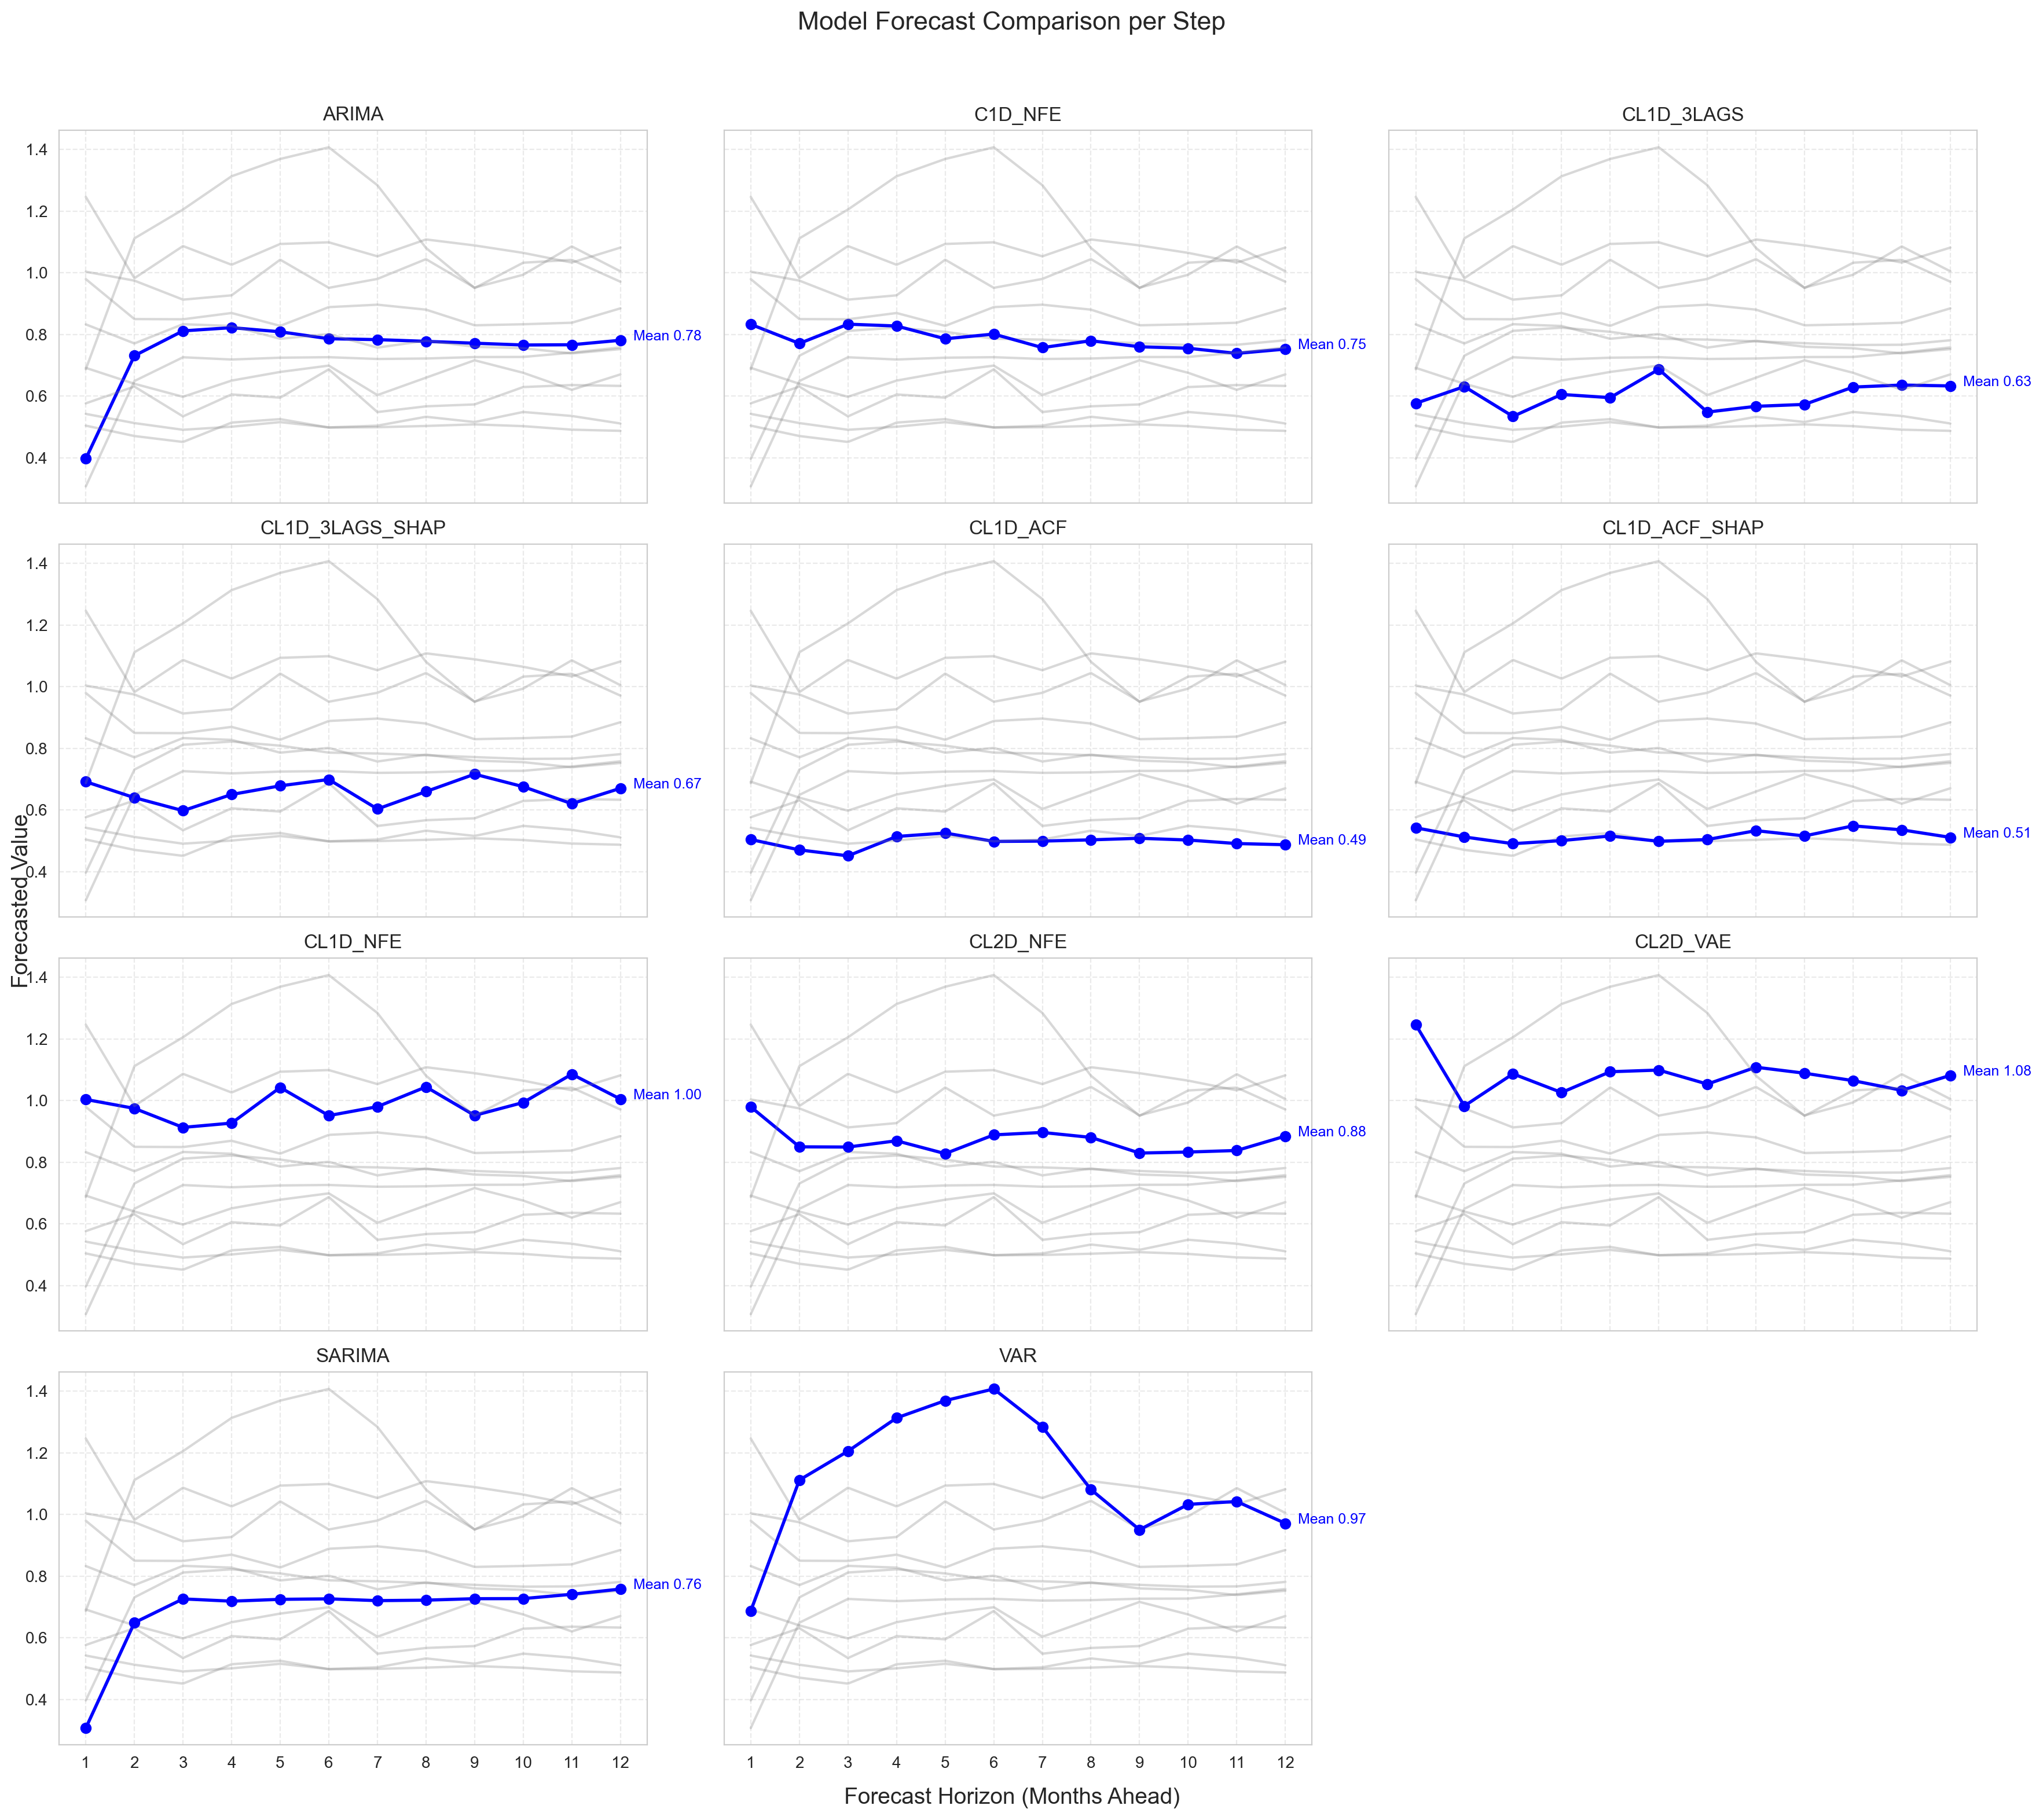

In [47]:
plot_multipanel_forecasts_highlighted(forecast_df, model_prefixes)
